In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, widgets
#from IPython.display import display
import scipy.linalg
import itertools
import scipy.misc as sc
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display
import pylab as pl
import time
from scipy import signal
from scipy import io
from skimage import transform
# import cupy as cp
import hdf5storage
import pywt
import copy
import math

import os

## Load Data

In [19]:
#h=hdf5storage.loadmat('C:\Research\RandoscopePSFS\\psf_2_5um_NovMono_comps.mat')  ## rank 12, z downsample by 4 (x,y,r,z)
#weights=hdf5storage.loadmat('C:\Research\RandoscopePSFS\\psf_2_5um_NovMono_weights.mat')

h=scipy.io.loadmat('/home/rshuai/research/u-net-reconstruction/data/PSFs/SVD_2_5um_PSF_5um_1_ds4_dsz1_comps_green_SubAvg.mat')  ## rank 12, z downsample by 4 (x,y,r,z)
weights=scipy.io.loadmat('/home/rshuai/research/u-net-reconstruction/data/PSFs/SVD_2_5um_PSF_5um_1_ds4_dsz1_weights_green_SubAvg.mat')

# h = np.load('../data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy')
# weights = np.load('../data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy')

# h = h.transpose(3, 2, 1, 0)
# weights = weights.transpose(3, 2, 1, 0)

KeyboardInterrupt: 

In [ ]:
xtrue=plt.imread('/home/rshuai/research/u-net-reconstruction/data/real-data/resTarget_2_MMStack_Img_15_000_000.ome_Z_030_T_001_res_target_paper.png')
plt.imshow(xtrue)
plt.colorbar()

In [ ]:
# restarget=hdf5storage.loadmat('C:\Research\RandoscopePSFS\\res_15_z30.mat')
# restarget=restarget['res_15_z30']
# restarget=restarget/np.max(restarget)
# y=np.maximum(restarget,0)
# plt.imshow(y)
# plt.colorbar()
# print(np.min(y))

In [ ]:
h=h['array_out']
weights=weights['array_out']
# make sure its (x,y,z,r)
h=np.swapaxes(h,2,3)
weights=np.swapaxes(weights,2,3)
# Normalize weights to have maximum sum through rank of 1
weights_norm = np.max(np.sum(weights[np.shape(weights)[0]//2-1,np.shape(weights)[1]//2-1,:,:],1))
weights = weights/weights_norm;

#normalize by norm of all stack. Can also try normalizing by max of all stack or by norm of each slice
h=h/np.linalg.norm(np.ravel(h))

In [ ]:
psf=np.zeros((np.shape(weights)[0],np.shape(weights)[1]))
for r in range (0,np.shape(weights)[3]):
    psf=psf+np.multiply(h[:,:,0,r],weights[:,:,0,r])
psf=psf/np.max(psf)
plt.imshow(psf)
plt.colorbar()

In [7]:
ccL = np.shape(h)[1]//2
ccU = 3*np.shape(h)[1]//2
rcL = np.shape(h)[0]//2
rcU = 3*np.shape(h)[0]//2
#H = np.fft.fft2(np.fft.ifftshift(np.fft.ifftshift(pad4d(h),0),1),axes=(0,1))

#H = np.fft.fft2(pad4d(h),axes=(0,1))
#Hconj = np.conj(H)

#Hnp = np.fft.fft2(np.fft.ifftshift(np.fft.ifftshift(h,0),1),axes=(0,1))
Hnp=np.zeros(np.shape(h))
Hconjnp=np.zeros(np.shape(h))
H=[]
Hconj=np.zeros(np.shape(h))
for i in range (np.shape(h)[3]):
    for z in range(np.shape(h)[2]):
        Hnp[:,:,z,i]=(np.fft.fft2(h[:,:,z,i]))
        Hconjnp[:,:,z,i]=(np.conj(Hnp[:,:,z,i]))
        #H.append(np.fft.fft2(pad2d(h[:,:,z,i])))
        #Hconj.append(np.conj(H[i]))
#Hnp=np.swapaxes(np.swapaxes(np.array(Hnp),0,1),1,2)
#H=crop4d(H,rcL,rcU,ccL,ccU)
#Hconjnp = np.swapaxes(np.swapaxes(np.array(Hconjnp),0,1),1,2)

#H=np.swapaxes(np.swapaxes(np.array(H),0,1),1,2)
#H=crop4d(H,rcL,rcU,ccL,ccU)
#Hconj = np.swapaxes(np.swapaxes(np.array(Hconj),0,1),1,2)

/home/rshuai/research/u-net-reconstruction/venv_unet/lib/python3.6/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


## Forward model

In [17]:
def pad2d (x):
    Ny=np.shape(x)[0]
    Nx=np.shape(x)[1]
    return np.pad(x,((Ny//2,Ny//2),(Nx//2,Nx//2)),'constant', constant_values=(0))

def pad4d(x):
    Ny=np.shape(x)[0]
    Nx=np.shape(x)[1]
    return np.pad(x,((Ny//2,Ny//2),(Nx//2,Nx//2),(0,0),(0,0)),'constant', constant_values=(0))

def crop4d(x,rcL,rcU,ccL,ccU):
    return x[rcL:rcU,ccL:ccU,:,:]

def crop2d(x,rcL,rcU,ccL,ccU):   
    return x[rcL:rcU,ccL:ccU]

def nocrop(x):
    return x

def nopad(x):
    return x

def A_2d_svd(x,H,weights,pad,mode='shift_variant'): #can remove some ifftshifts
    x=pad(x)
    Y=np.zeros((np.shape(x)[0],np.shape(x)[1]))
        
    if (mode =='shift_variant'):
        for r in range (0,np.shape(weights)[2]):
            X=np.fft.fft2((np.multiply(pad(weights[:,:,r]),x)))
            Y=Y+ np.multiply(X,H[:,:,r])
    
    return np.real((np.fft.ifftshift(np.fft.ifft2(Y))))

def A_2d(x,psf,pad):
    X=np.fft.fft2((pad(x)))
    H=np.fft.fft2((pad(psf)))
    Y=np.multiply(X,H)
    
    return np.real((np.fft.ifftshift(np.fft.ifft2(Y))))

def A_2d_adj_svd(Hconj,weights,y,pad):
    y=pad(y)
    x=np.zeros((np.shape(y)[0],np.shape(y)[1]))
    for r in range (0, np.shape(weights)[2]):
        x=x+np.multiply(pad(weights[:,:,r]),(np.real(np.fft.ifftshift(np.fft.ifft2(np.multiply(Hconj[:,:,r], np.fft.fft2((y))))))))
    #note the weights are real so we dont take the complex conjugate of it, which is the adjoint of the diag 
    return x

def A_2d_adj(y,psf,pad):
    H=np.fft.fft2((pad(psf)))
    Hconj=np.conj(H)
    x=(np.real(np.fft.ifftshift(np.fft.ifft2(np.multiply(Hconj, np.fft.fft2((pad(y))))))))
    
    return x

def A_3d(x,h,pad):
    #h is the psf stack
    #x is the variable to convolve with h
    x=pad(x)
    B=np.zeros((np.shape(x)[0],np.shape(x)[1]))
        

    for z in range (0,np.shape(h)[2]):
        #X=np.fft.fft2((np.multiply(pad(weights[:,:,z]),x)))
        B=B+ np.multiply(np.fft.fft2(x[:,:,z]),np.fft.fft2(pad(h[:,:,z])))
    
    return np.real((np.fft.ifftshift(np.fft.ifft2(B))))


def A_3d_svd(v,alpha,H,pad):
    #alpha is Ny-Nx-Nz-Nr, weights
    #v is Ny-Nx-Nz
    #H is Ny-Nx-Nz-Nr
    # b= sum_r (sum_z (h**alpra.*v))
    b=np.zeros((np.shape(v)[0],np.shape(v)[1]))
    for r in range (np.shape(H)[3]):
        for z in range (np.shape(H)[2]):
            b=b+np.multiply(H[:,:,z,r],np.fft.fft2(np.multiply(v[:,:,z],alpha[:,:,z,r])))
    
    return np.real(np.fft.ifftshift(np.fft.ifft2(b)))

def A_3d_adj(x,h,pad):
    y=np.zeros(np.shape(h))
    X=np.fft.fft2(pad(x))
    for z in range(np.shape(h)[2]):
        H=np.conj(np.fft.fft2(pad(h[:,:,z])))
        y[:,:,z]=np.real(np.fft.ifftshift(np.fft.ifft2(np.multiply(H,X))))
    return y

def A_3d_adj_svd(b,alpha,Hconj,pad):
    #y=sum_r(alpha.*H_conj**b)
    y=np.zeros((np.shape(alpha)[0],np.shape(alpha)[1],np.shape(alpha)[2]))
    B=np.fft.fft2(pad(b))
    for z in range(np.shape(alpha)[2]):
        for r in range(np.shape(alpha)[3]):
            y[:,:,z]=y[:,:,z]+np.multiply(alpha[:,:,z,r],np.fft.ifftshift(np.fft.ifft2(np.multiply(B,Hconj[:,:,z,r]))))
        
    return y

def grad(v):
    return np.array(np.gradient(v))  #returns gradient in x and in y


def grad_adj(v):  #adj of gradient is negative divergence
    z = np.zeros((n,n)) + 1j
    z -= np.gradient(v[0,:,:])[0]
    z -= np.gradient(v[1,:,:])[1]
    return z

def soft2(dv,thresh,n):                    # Gradient soft-thresholding
    dv_flat = np.reshape(dv,(2,-1))      # Flatten image to vector (2 vectors, dx and dy)
    mag = np.linalg.norm(dv_flat,2,0)        # Magnitude of gradient at each pixel 
    magt = np.maximum(mag - thresh,0)    # soft threshold the magnitude 
    mult = magt/mag                      # multiplier 
    out = np.tile(mult,(2,1))*dv_flat
    
    return np.reshape(out,(2,n,n))

def soft_thresh(w,lam):
    return np.sign(w)*np.maximum(np.abs(w)-lam, 0)

def soft_nonneg(x,lam):
    return np.maximum(x-lam,0)

def linear_gradient_b(x, A, At,b):  #this function just calcualtes At(Ax-b)
    
    g = At(A(x)-b)
    f = 0.5*(np.linalg.norm(np.ravel(A(x)-b))**2)
    return f,g   #returns gradient (g) and cost function value (f)

def fista(GradErrHandle,ProxFunc,xk,b,options):
    #A nesterov accelerated proximal gradient solver
    #GradErrHandle: handle for function that computes error and gradient at each step
    #ProxFunc: handle for function that does projection step
    loss_df=[]
    loss_total=[]
    loss_norm=[]
    tk = 1
    yk = xk
    for step_num in range(options.maxIter):
        [f_kp1, g] = GradErrHandle(yk)
        [x_kp1, norm_x] = ProxFunc(yk-options.stepsize*g)
        loss_df.append(f_kp1)
        loss_norm.append(norm_x)
        loss_total.append(loss_norm[step_num]+loss_df[step_num])
        t_kp1 = (1+np.sqrt(1+4*tk**2))/2
        beta_kp1 = (tk-1)/t_kp1
        restart = np.dot(np.ravel(yk)-np.ravel(x_kp1),np.ravel(x_kp1 - xk))
        yk = x_kp1+beta_kp1*(x_kp1 - xk)
        xk=x_kp1
        tk=t_kp1
        
        if (options.plotting==1):
            if (np.mod(step_num,10)==0):
                ax1=plt.subplot(1,2,1)
                ax1.clear()
                im1=ax1.plot(loss_df)
                display.clear_output(wait=True)
                display.display(pl.gcf())
                ax2=plt.subplot(1,2,2)
                ax2.clear()
                im2=ax2.imshow(yk)

        if (loss_total[step_num]<options.residTol): 
            print('Answer stable within ResidTol')
            break
        elif (np.abs(restart)<options.convTol):
            print('Anwswer stable within ConvTol')
            break
    
    return yk,loss_total,loss_df,loss_norm

def fista_nonneg(GradErrHandle,ProxFunc,xk,b,options):
    #A nesterov accelerated proximal gradient solver with nonnegative constraint
    #GradErrHandle: handle for function that computes error and gradient at each step
    #ProxFunc: handle for function that does projection step
    #composing regularizers works slightly better than averaging them
    loss_df=[]
    loss_total=[]
    loss_norm=[]
    tk = 1
    yk = xk
    for step_num in range(options.maxIter):
        [f_kp1, g] = GradErrHandle(yk)
        #print(options.stepsize*g[200,200,0])
        [x_kp1, norm_x] = ProxFunc(yk-options.stepsize*g)
        #print(np.sum(np.ravel(x_kp1)-np.ravel(yk-options.stepsize*g)))
        #x_kptv = soft_thresh(yk-options.stepsize*g,options.stepsize*options.tau)
        #[x_kpl1, norm_x] = tvdenoise(yk-options.stepsize*g,options.stepsize*options.tautv,10,opt='iso',plot=0)
        #x_kp1=(x_kptv+x_kpl1)/2
        loss_df.append(f_kp1)
        loss_norm.append(norm_x)
        loss_total.append(loss_norm[step_num]+loss_df[step_num])
        t_kp1 = (1+np.sqrt(1+4*tk**2))/2
        beta_kp1 = (tk-1)/t_kp1
        restart = np.dot(np.ravel(yk)-np.ravel(x_kp1),np.ravel(x_kp1 - xk))
        yk = np.maximum(x_kp1+beta_kp1*(x_kp1 - xk),0)
        xk=x_kp1
        tk=t_kp1
        if (options.plotting==1):
            if (options.dim=='2d'):
                if (np.mod(step_num,10)==0):
                    ax1=plt.subplot(1,2,1)
                    ax1.clear()
                    im1=ax1.plot(loss_df)
                    display.clear_output(wait=True)
                    display.display(pl.gcf())
                    ax2=plt.subplot(1,2,2)
                    ax2.clear()
                    im2=ax2.imshow(yk)
            elif(options.dim=='3d'):
                if (np.mod(step_num,10)==0):
                    ax1=plt.subplot(1,2,1)
                    ax1.clear()
                    im1=ax1.semilogy(loss_df)
                    display.clear_output(wait=True)
                    display.display(pl.gcf())
                    ax2=plt.subplot(1,2,2)
                    ax2.clear()
                    im2=ax2.imshow(np.sum(yk,2))

        if (loss_total[step_num]<options.residTol): 
            print('Answer stable within ResidTol')
            break
        elif (np.abs(restart)<options.convTol):
            print('Anwswer stable within ConvTol')
            break
    
    return yk,loss_total,loss_df,loss_norm

def projected_fista(GradErrHandle,ProxFunc,xInit,y,options):
    #A projected nesterov accelerated proximal gradient solver with adaptive step size
    # adaptive step size to adapt to the local curvature of the cost function
    #and restart to ensure monotonicity of the resulting iteration
    #GradErrHandle: handle for function that computes error and gradient at each step
    #ProxFunc: handle for function that does projection step
    #hardcoded projection function as nonnegativity. can be changed
    #using adaptive step and backtracking provides better results
    #this code is from this paper: Projected Nesterov’s Proximal-Gradient Algorithm for Sparse Signal Reconstruction with a Convex Constraint 
    #testing on 2D randoscope 4x downsample, rank 12: it runs at 1.44sec/iter as compared to 1.11sec/iter for fista_nonneg but gets 60x better loss
    
    #NOTE: The idea is we will increase the step size every cumuTol iteration, but each iteration, we are doing backtracking. we are checking if marjorization 
    #condition holds, if it does, break and keep going with the step size you have. If not, then we keep shrinking the stepsize until the majorization condition holds.
    #adaptive step parameters
    adaptiveStep=1
    if (adaptiveStep):
        cumu=0 
    cumuTol=4  #perform adaptive step every this iteration
    stepIncre=0.5**0.2

    
    #accelration tuning parameters
    gamma=2 #gamma should be >=2
    b=0.25 # b between [0,0.25]
    theta=1
    x=xInit
    preX=x
    
    P=np.zeros((np.shape(y)[0],np.shape(y)[1],3))
    #proximal step tuning paramters for line search
    u=options.tau#1e-4 default. This is the regularization parameter
    uhess=options.tauhess
    utv=options.tautv
    preSteps=0
    maxLineSearch=10#20 default #how many line searches to do for backtracking
    Lip=1e6
    goodStep='true'
    stepShrnk=0.5
    incCumuTol='true'
    [NLLVal,g_bad]=GradErrHandle(xinit)
    if (options.reg=='l1'):
        penVal=np.sum(np.abs(xinit))
    elif(options.reg=='tv_iso'):
        loss=np.gradient(xinit)
        penVal=np.sum(np.sqrt(np.square(np.ravel(loss[0]))+np.square(np.ravel(loss[1]))))
        
        
    elif(options.reg=='tv_l1' or options.reg=='tv_haar' or options.reg=='hess' ):
        loss=np.gradient(xinit)
        penVal=np.sum(np.abs(np.ravel(loss)))
    cost=NLLVal+u*penVal
    convThresh=0
    itrRes=0
    
    #Use BB method to guess the initial stepsize
    delta=1e-5
    [nada,grad1] = GradErrHandle(xinit);
    temp = delta*grad1/np.linalg.norm(grad1);
    temp = x-np.maximum(x-temp,0);
    [nada,grad2] = GradErrHandle(x-temp)
    t = np.abs(np.dot(np.ravel(grad1-grad2),np.ravel(temp)))/(np.linalg.norm(temp)**2)
            
   
    loss_df=[]
    loss_total=[]
    loss_norm=[]
    tk = 1
    minItr=10
    thresh=1e-6 #was 1e-6
    t_vis=[]

    for itr in range(1,options.maxIter):
        if (convThresh>=3):
            print('Answer Stable Within ConvTol')
            break
#         if (convThresh>=3):
#             break
        
        ##### Start of one Projected Nesterov proximal gradien step #####
        numLineSearch=0; goodMM='true'; incStep='false';
        #adaptively increase step size
        if(adaptiveStep):
            if(cumu>=cumuTol):
                t=t*stepIncre;
                cumu=0;
                incStep='true';
        else:
        #accelration step
            if(itr==1):
                newTheta=1;
            else:
                newTheta=1/gamma+np.sqrt(b+theta**2);
            xbar=x+((theta-1)/newTheta)*(x-preX); #acceleration step
            xbar=np.maximum(xbar,0) #projectfunc
            [oldNLL,grad] = GradErrHandle(xbar)

        loop='true'
        
        #start of line search
        # the goal is to make the step size as big as possible while still ensuring the majorization conditoin holds
        # check if the majorization condition holds. That is that the loss after gradient descent and prox is less that the quadratic loss
        # If condition holds, keep going and increase step every cumu iterations, if it doesnt hold, shrink the step size
        while(loop=='true'):
            numLineSearch = numLineSearch+1;
            if (adaptiveStep):
                #adaptive step
                if(itr==1):
                    newTheta=1;
                else:
                    B=t/preT;
                    newTheta=1/gamma+np.sqrt(b+B*theta**2);       
                xbar=x+(theta-1)/newTheta*(x-preX);
                xbar=np.maximum(xbar,0);  #project func
                [oldNLL,grad] = GradErrHandle(xbar); #error before prox or stepping
            
            #proximalstep
            #print(1/t)
            if(options.reg=='l1'):
                newX=soft_thresh(xbar-grad/t,u/t);
            elif(options.reg=='hess'):
                [newX,P]=hessian_denoise(xbar-grad/t,uhess/t,10,P, 2)
                penloss=0
            elif(options.reg=='tv_iso'):
                if options.dim=='2d':
                    [newX,penloss]=tvdenoise(xbar-grad/t,utv/t,10,opt='iso')
                elif options.dim=='3d':
                    [newX,penloss]=tvdenoise_chambolle(xbar-grad/t,utv/t,10)
            elif(options.reg=='tv_l1'):
                [newX,penloss]=tvdenoise(xbar-grad/t,utv/t,10,opt='l1')
            elif(options.reg=='tv_haar'):
                if options.dim=='2d':
                    [newX,penloss]=tv2d_aniso_haar(xbar-grad/t,utv/t)
                elif options.dim=='3d':
                    [newX,penloss]=tv3d_iso_haar(xbar-grad/t,utv/t,1)
            [newNLL,test]=GradErrHandle(newX); #error after stepping and prox

            #checking if majorization condition holds (meaning that our quadratic approximation is always
            #above our loss function) Datafedility loss at after prox is less than quadratic term
            #print((newNLL-oldNLL))
            #print(np.dot(np.ravel(newX-xbar),np.ravel(grad))+t*np.sum(np.multiply(newX-xbar,newX-xbar))/2)
            if((newNLL-oldNLL)<=np.dot(np.ravel(newX-xbar),np.ravel(grad))+t*(np.linalg.norm(newX-xbar)**2)/2):
                if(itr<=preSteps and adaptiveStep and goodStep=='true'):
                    cumu=cumuTol
                break
            else:
                if(numLineSearch<=maxLineSearch and t<Lip):
                    t=t/stepShrnk; goodStep='false';
                    # Penalize if there is a step size increase just now
                    if(incStep=='true'):
                        incStep='false';
                        if(incCumuTol):
                            cumuTol=cumuTol+4;

                else: # % don't know what to do, mark on debug and break
                    goodMM='false';
                    break;

        if(options.reg=='l1'):
            newPen=np.sum(np.abs(newX))
        elif (options.reg=='tv_iso' or options.reg=='tv_l1' or options.reg=='tv_haar' or options.reg=='hess'):
            newPen=penloss
        newCost=newNLL+u*newPen
        #using eps reduces numerical issue around the point of convergence
        if((newCost-cost)>1e-14*np.linalg.norm(np.ravel(np.vstack((newCost,cost))),np.inf)):
            if(goodMM=='true'):
                restart=((np.linalg.norm(np.ravel(xbar-x),0)!=0) and (oldNLL+u*np.sum(np.abs(xbar))>newCost))
                #runMore=0
                if(restart): #or runMore):
                    # It has some doubt whether put the following line "theta=1" in restart() or
                    # here.  We choose to put it here to be conservative.
                    theta=1;
                    itr=itr-1;
                    itrRes=itr;
                    continue;


            # give up and force it to converge
            preX=x; difX=0;
            preCost=cost;
        else:
                
            nm=np.linalg.norm(np.ravel(x)-np.ravel(newX)); 
            normb=np.maximum(np.linalg.norm(np.ravel(x)), np.linalg.norm(np.ravel(b)));
            difX = nm/np.maximum(normb,1);
            preX = x;
            x = newX;
            theta = newTheta;
            preCost=cost;
            cost = newCost;
            NLLVal=newNLL;
            penVal=newPen;
        
        if(adaptiveStep):
            preT=t
            if(numLineSearch==1):
                cumu=cumu+1;
            else:
                cumu=0;
        
        ##### End of one Projected Nesterov proximal gradien step #####

        loss_total.append(cost)
        loss_df.append(NLLVal)
        loss_norm.append(penVal)
        t_vis.append(1/t)


        if (options.plotting==1):
            if (options.dim=='2d'):
                if (np.mod(itr,20)==0):
                    ax1=plt.subplot(1,2,1)
                    ax1.clear()
                    im1=ax1.semilogy(loss_total)
                    display.clear_output(wait=True)
                    display.display(pl.gcf())
                    ax2=plt.subplot(1,2,2)
                    ax2.clear()
                    im2=ax2.imshow(x)
            elif(options.dim=='3d'):
                if (np.mod(itr,1)==0):
                    ax1=plt.subplot(1,2,1)
                    ax1.clear()
                    im1=ax1.semilogy(loss_total)
                    display.clear_output(wait=True)
                    display.display(pl.gcf())
                    ax2=plt.subplot(1,2,2)
                    ax2.clear()
                    im2=ax2.imshow(np.sum(x,2))
                
        if(difX<=thresh and itr>=minItr):
            convThresh=convThresh+1;

        if (loss_total[itr-1]<options.residTol):
            print('Answer Stable within ResidTol')
            break
    
    return x,loss_total,loss_df,loss_norm,t_vis


#removed non neg to test on real data!

##NOTE: the penalty value is not multiplied by the correct regularization parameter. 
def parallel_projected_fista(GradErrHandle,ProxFunc,xInit,y,options):
    #A projected nesterov accelerated proximal gradient solver with adaptive step size
    # adaptive step size to adapt to the local curvature of the cost function
    #and restart to ensure monotonicity of the resulting iteration
    #GradErrHandle: handle for function that computes error and gradient at each step
    #ProxFunc: handle for function that does projection step
    #hardcoded projection function as nonnegativity. can be changed
    #using adaptive step and backtracking provides better results
    #this code is from this paper: Projected Nesterov’s Proximal-Gradient Algorithm for Sparse Signal Reconstruction with a Convex Constraint 
    #testing on 2D randoscope 4x downsample, rank 12: it runs at 1.44sec/iter as compared to 1.11sec/iter for fista_nonneg but gets 60x better loss
    
    #NOTE: The idea is we will increase the step size every cumuTol iteration, but each iteration, we are doing backtracking. we are checking if marjorization 
    #condition holds, if it does, break and keep going with the step size you have. If not, then we keep shrinking the stepsize until the majorization condition holds.
    
    #adaptive fista is way better than fista
    #This parallel version uses parallel proximal with data fidelity to use many regularizers. This comes from Ulugbek's 
    #parallel proximal TV paper, page 3 mixed with projected nesterove fista
    
    #adaptive step parameters
    adaptiveStep=1
    if (adaptiveStep):
        cumu=0 
    cumuTol=4  #perform adaptive step every this iteration
    stepIncre=0.5**0.2

    
    #accelration tuning parameters
    gamma=2 #gamma should be >=2
    b=0.25 # b between [0,0.25]
    theta=1
    x=xInit
    preX=x
    
    #proximal step tuning paramters for line search
    u=options.tau#1e-4 default. This is the regularization parameter
    uwav=options.tauwav
    utv=options.tautv
    uhess=options.tauhess
    preSteps=0
    maxLineSearch=10#20 default #how many line searches to do for backtracking
    Lip=1e6
    goodStep='true'
    stepShrnk=0.5
    incCumuTol='true'
    [NLLVal,g_bad]=GradErrHandle(xinit)
    
    #dual variable R, P for hessian
    if options.hess=='spec_norm':
        P=np.zeros((np.shape(y)[0],np.shape(y)[1],2))
        R=np.zeros((np.shape(y)[0],np.shape(y)[1]))
    elif options.hess=='fro_norm':
        P=np.zeros((np.shape(y)[0],np.shape(y)[1],3))
        R=np.zeros((np.shape(y)[0],np.shape(y)[1]))
    
    
    
    if (options.reg=='l1'):
        penVal=np.sum(np.abs(xinit))
    elif(options.reg=='tv_iso'):
        loss=np.gradient(xinit)
        penVal=np.sum(np.sqrt(np.square(np.ravel(loss[0]))+np.square(np.ravel(loss[1]))))     
        
    elif(options.reg=='tv_l1'or options.reg=='tv_haar'):
        loss=np.gradient(xinit)
        penVal=np.sum(np.abs(np.ravel(loss[0]))+np.abs(np.ravel(loss[1])))
        
    elif(options.reg=='l1_tv_l1' or options.reg=='l1_tv_haar'):
        loss=np.gradient(xinit)
        penVal=np.sum(np.abs(np.ravel(loss[0]))+np.abs(np.ravel(loss[1])))+np.sum(np.abs(xinit))
        
    elif(options.reg=='l1_tv_iso'):
        loss=np.gradient(xinit)
        penVal=np.sum(np.sqrt(np.square(np.ravel(loss[0]))+np.square(np.ravel(loss[1]))))+np.sum(np.abs(xinit)) 
    
    elif(options.reg=='l1_tv_haar_wav'):
        coeffs = pywt.wavedec2(xinit, wavelet='db4', mode='per', level=4)
        penloss_wav=0
        for wav in range(np.shape(coeffs)[0]):
         
            penloss_wav=penloss_wav+np.sum(np.abs(coeffs[wav]))
        
        
        loss=np.gradient(xinit)
        penVal=np.sum(np.abs(np.ravel(loss[0]))+np.abs(np.ravel(loss[1])))+np.sum(np.abs(xinit))+penloss_wav
        
    elif(options.reg=='l1_tv_haar_hess'):
        

        loss=np.gradient(xinit)
        penVal=np.sum(np.abs(np.ravel(loss[0]))+np.abs(np.ravel(loss[1])))+np.sum(np.abs(xinit))
        
        
    #print(options.reg)    
    cost=NLLVal+u*penVal
    convThresh=0
    itrRes=0
    
    #Use BB method to guess the initial stepsize
    delta=1e-5
    [nada,grad1] = GradErrHandle(xinit);
    temp = delta*grad1/np.linalg.norm(grad1);
    temp = x-np.maximum(x-temp,0);
    [nada,grad2] = GradErrHandle(x-temp)
    t = np.abs(np.dot(np.ravel(grad1-grad2),np.ravel(temp)))/(np.linalg.norm(temp)**2)
            
   
    loss_df=[]
    loss_total=[]
    loss_norm=[]
    tk = 1
    minItr=10
    thresh=1e-6 #was 1e-6
    t_vis=[]

    for itr in range(1,options.maxIter):
        if (convThresh>=3):
            print('Answer Stable within ConvTol')
            break
#         if (convThresh>=3):
#             break
        
        ##### Start of one Projected Nesterov proximal gradien step #####
        numLineSearch=0; goodMM='true'; incStep='false';
        #adaptively increase step size
        if(adaptiveStep):
            if(cumu>=cumuTol):
                t=t*stepIncre;
                cumu=0;
                incStep='true';
        else:
        #accelration step
            if(itr==1):
                newTheta=1;
            else:
                newTheta=1/gamma+np.sqrt(b+theta**2);
            xbar=x+((theta-1)/newTheta)*(x-preX); #acceleration step
            xbar=np.maximum(xbar,0) #projectfunc
            [oldNLL,grad] = GradErrHandle(xbar)

        loop='true'
        
        #start of line search
        # the goal is to make the step size as big as possible while still ensuring the majorization conditoin holds
        # check if the majorization condition holds. That is that the loss after gradient descent and prox is less that the quadratic loss
        # If condition holds, keep going and increase step every cumu iterations, if it doesnt hold, shrink the step size
        while(loop=='true'):
            
            numLineSearch = numLineSearch+1;
            if (adaptiveStep):
                #adaptive step
                if(itr==1):
                    newTheta=1;
                else:
                    B=t/preT;
                    newTheta=1/gamma+np.sqrt(b+B*theta**2);       
                xbar=x+(theta-1)/newTheta*(x-preX);
                xbar=np.maximum(xbar,0);  #project func
                [oldNLL,grad] = GradErrHandle(xbar); #error before prox or stepping
            
            #proximalstep
            #print(1/t)
            if(options.reg=='l1'):
                newX=soft_thresh(xbar-grad/t,u/t);
            elif(options.reg=='tv_iso'):
                [newX,penloss]=tvdenoise(xbar-grad/t,utv/t,10,opt='iso')
            elif(options.reg=='tv_l1'):
                [newX,penloss]=tvdenoise(xbar-grad/t,utv/t,10,opt='l1')
            elif(options.reg=='tv_haar'):
                [newX,penloss]=tv2d_aniso_haar(xbar-grad/t,utv/t)
            elif(options.reg=='l1_tv_iso'):
                [newXtv,penloss]=tvdenoise(xbar-grad/t,utv/t,10,opt='iso')
                newXl1=soft_thresh(xbar-grad/t,u/t);
                newX=(newXl1+newXtv)/2
                penloss=penloss+np.sum(np.abs(newXl1))
            elif(options.reg=='l1_tv_l1'):
                [newXtv,penloss]=tvdenoise(xbar-grad/t,utv/t,10,opt='l1')
                newXl1=soft_thresh(xbar-grad/t,u/t);
                newX=(newXl1+newXtv)/2
                penloss=penloss+np.sum(np.abs(newXl1))
            elif(options.reg=='l1_tv_haar'):
                [newXtv,penloss]=tv2d_aniso_haar(xbar-grad/t,utv/t)
                newXl1=soft_thresh(xbar-grad/t,u/t);
                newX=(newXl1+newXtv)/2
                penloss=penloss+np.sum(np.abs(newXl1))
            
            elif(options.reg=='l1_tv_haar_wav'):
                [newXtv,penloss]=tv2d_aniso_haar(xbar-grad/t,utv/t)
                newXl1=soft_thresh(xbar-grad/t,u/t);
                
                
                
                coeffs = pywt.wavedec2(xbar-grad/t, wavelet='db4', mode='per', level=4)
                penloss_wav=0
                for wav in range(np.shape(coeffs)[0]):
                    coeffs[wav]=soft_thresh(coeffs[wav],uwav/t);
                    penloss_wav=penloss_wav+np.sum(np.abs(coeffs[wav]))

                newXwav=pywt.waverec2(coeffs, wavelet='db4', mode='per')
                newX=(newXl1+newXtv+newXwav)/3
                penloss=penloss+np.sum(np.abs(newXl1))+penloss_wav
                
            elif(options.reg=='l1_tv_haar_hess'):
                [newXtv,penloss]=tv2d_aniso_haar(xbar-grad/t,utv/t)
                newXl1=soft_thresh(xbar-grad/t,u/t);
                #[Xhess,R,P]=hessian_prox(xbar-grad/t,uhess/t,10,R,P,opt=options.hess)#can be spec_norm or fro_norm
                [Xhess,P]=hessian_denoise(xbar-grad/t,uhess/t,10,P, 1)




                newX=(newXl1+newXtv+Xhess)/3
                penloss=penloss+np.sum(np.abs(newXl1))
                
            
                
            
                
                
            [newNLL,test]=GradErrHandle(newX); #error after stepping and prox

            #checking if majorization condition holds (meaning that our quadratic approximation is always
            #above our loss function) Datafedility loss at after prox is less than quadratic term
            #print((newNLL-oldNLL))
            #print(np.dot(np.ravel(newX-xbar),np.ravel(grad))+t*np.sum(np.multiply(newX-xbar,newX-xbar))/2)
            if((newNLL-oldNLL)<=np.dot(np.ravel(newX-xbar),np.ravel(grad))+t*(np.linalg.norm(newX-xbar)**2)/2):
                if(itr<=preSteps and adaptiveStep and goodStep=='true'):
                    cumu=cumuTol
                break
            else:
                if(numLineSearch<=maxLineSearch and t<Lip):
                    t=t/stepShrnk; goodStep='false';
                    # Penalize if there is a step size increase just now
                    if(incStep=='true'):
                        incStep='false';
                        if(incCumuTol):
                            cumuTol=cumuTol+4;

                else: # % don't know what to do, mark on debug and break
                    goodMM='false';
                    break;

        if(options.reg=='l1'):
            newPen=np.sum(np.abs(newX))
        elif (options.reg=='tv_iso' or options.reg=='tv_l1' or options.reg=='l1_tv_l1' or options.reg=='l1_tv_iso' or options.reg=='l1_tv_haar' or options.reg=='tv_haar' or options.reg=='l1_tv_haar_wav' or options.reg=='l1_tv_haar_hess'):
            newPen=penloss
        
        newCost=newNLL+u*newPen
        #using eps reduces numerical issue around the point of convergence
        if((newCost-cost)>1e-14*np.linalg.norm(np.ravel(np.vstack((newCost,cost))),np.inf)):
            if(goodMM=='true'):
                restart=((np.linalg.norm(np.ravel(xbar-x),0)!=0) and (oldNLL+u*np.sum(np.abs(xbar))>newCost))
                #runMore=0
                if(restart): #or runMore):
                    # It has some doubt whether put the following line "theta=1" in restart() or
                    # here.  We choose to put it here to be conservative.
                    theta=1;
                    itr=itr-1;
                    itrRes=itr;
                    continue;


            # give up and force it to converge
            preX=x; difX=0;
            preCost=cost;
        else:
                
            nm=np.linalg.norm(np.ravel(x)-np.ravel(newX)); 
            normb=np.maximum(np.linalg.norm(np.ravel(x)), np.linalg.norm(np.ravel(b)));
            difX = nm/np.maximum(normb,1);
            preX = x;
            x = newX;
            theta = newTheta;
            preCost=cost;
            cost = newCost;
            NLLVal=newNLL;
            penVal=newPen;
        
        if(adaptiveStep):
            preT=t
            if(numLineSearch==1):
                cumu=cumu+1;
            else:
                cumu=0;
        
        ##### End of one Projected Nesterov proximal gradien step #####

        loss_total.append(cost)
        loss_df.append(NLLVal)
        loss_norm.append(penVal)
        t_vis.append(1/t)


        if (options.plotting==1):
            if (options.dim=='2d'):
                if (np.mod(itr,20)==0):
                    ax1=plt.subplot(1,2,1)
                    ax1.clear()
                    im1=ax1.plot(loss_total)
                    display.clear_output(wait=True)
                    display.display(pl.gcf())
                    ax2=plt.subplot(1,2,2)
                    ax2.clear()
                    im2=ax2.imshow(x)
            elif(options.dim=='3d'):
                if (np.mod(itr,20)==0):
                    ax1=plt.subplot(1,2,1)
                    ax1.clear()
                    im1=ax1.plot(loss_total)
                    display.clear_output(wait=True)
                    display.display(pl.gcf())
                    ax2=plt.subplot(1,2,2)
                    ax2.clear()
                    im2=ax2.imshow(np.sum(x,2))
                
        if(difX<=thresh and itr>=minItr):
            convThresh=convThresh+1;

        if (loss_total[itr-1]<options.residTol):
            print('Answer Stable within ResidTol')
            break
    
    return x,loss_total,loss_df,loss_norm,t_vis

def tvLforward(p1,p2): #this is the adjoint to the finite difference
    [m2,n2]=np.shape(p1)
    [m1,n1]=np.shape(p2)
    m=m2+1;
    n=n2;
    X=np.zeros((m,n));

    X[0:m-1,:]=p1;
    X[:,0:n-1]=X[:,0:n-1]+p2;
    X[1:m,:]=X[1:m,:]-p1;
    X[:,1:n]=X[:,1:n]-p2;
    return X
def tvLadj(X): #this outputs finite difference in x and y
    m=np.shape(X)[0];
    n=np.shape(X)[1]
    P1=X[0:m-1,:]-X[1:m,:];
    P2=X[:,0:n-1]-X[:,1:n];
    return P1,P2

def tvdenoise(b,lam,N, opt='iso',plot=0):
    # b is observed image
    #lam is regularization parameter
    # N is number of iterations
    m=np.shape(b)[0]
    n=np.shape(b)[1]
    p1=np.zeros((m-1,n))
    r1=p1  #removed r1 and r2 to save mo
    p2=np.zeros((m,n-1))
    r2=p2
    dim=np.shape(np.shape(b))[0] #2D or 3D TV
    epsilon=1e-4 #threshold to terminate tv is x is not changing
    tk=1;
    tkp1=1;
    count=0;
    if (dim==2): #2D TV
        x=np.zeros((m,n)) #initial value

        for i in range (N):
            if (count>=5):
                break
            #storing old value of current solution
            xold=x 
            
            #computing the gradient of the objective function
            p1old=p1
            p2old=p2
            tk=tkp1
            x=b-lam*tvLforward(r1,r2)
            [q1,q2]=tvLadj(x)
            
            #Taking a step towards minus of the gradient
            p1=r1+1/(8*lam)*q1
            p2=r2+1/(8*lam)*q2
            #performing the projection step for iso and anisotropic TV
            if opt=='iso':#statyisfying |p|i<=1 and p**2+q**<=1
                A=(np.vstack((p1,np.zeros((1,n)))))**2+(np.hstack((p2,np.zeros((m,1)))))**2
                A=np.sqrt(np.maximum(A,1))
                p1=np.divide(p1,A[0:m-1,:])
                p2=np.divide(p2,A[:,0:n-1])
            elif opt=='l1':   #statyisfying |p|i<=1
                p1=np.divide(p1,(np.maximum(np.abs(p1),1)));
                p2=np.divide(p2,(np.maximum(np.abs(p2),1)));
                
            #Updating R and t
            tkp1=(1+np.sqrt(1+4*tk**2))/2;
            r1=p1+(tk-1)/(tkp1)*(p1-p1old);
            r2=p2+(tk-1)/tkp1*(p2-p2old);
            
            re=np.linalg.norm(np.ravel(x-xold))/np.linalg.norm(np.ravel(x))
            
            if (re<epsilon):
                count=count+1
            else:
                count=0
                
            if (plot==1):
                ax1=plt.subplot(1,1,1)
                ax1.clear()
                im1=ax1.imshow(x,vmax=0.1)
                display.clear_output(wait=True)
                display.display(pl.gcf())
                time.sleep(0.02)  
            
    #elif (dim==3): #3D TV
#         for i in range (N):
    loss=np.gradient(x)
    if opt=='iso':
        loss=np.sum(np.sqrt(np.square(np.ravel(loss[0]))+np.square(np.ravel(loss[1]))))
    elif opt=='l1':
        loss=np.sum(np.abs(np.ravel(loss[0]))+np.abs(np.ravel(loss[1])))
    return x,loss

def conjgrad(Afor,b,xinit,Niter):   
    z=xinit
    r = b - Afor(z)                # Calculate the residual, r
    p = r.copy()                     
    rsold = np.conj(r.ravel()).dot(r.ravel())
    
    for i in range(0, Niter):               #10 is a good number     # Loop for Niter
        
        Ap = Afor(p)
        alpha = rsold / (np.conj(p.ravel()).dot(Ap.ravel()))
        z = z + alpha*p
        r = r - alpha*Ap
        rsnew = np.conj(r.ravel()).dot(r.ravel())
        if np.sqrt(rsnew) < 1e-10:
              break
        p = r + (rsnew / rsold) * p
        rsold = rsnew
        #print(rsnew)
    return z

def prox_decomp(GradErrHandle,ProxFunc,Aadj,Afor,xInit,b,options):  #this is the same as parallel proximal
    # too slow because of how data fedility prox is calculated
    #Note this can be adjusted to parallel prox which deals with getting proxes of regularizers in multiple domains
    # native and wavelets and others. This will a lot of wavelt transforms (if wavelet sparsity is chosen), htereis an 
    #accelerated version of this that just requires 3 tansforms per iterations so better to use it if nativally, you are working with
    #cost ufnctions >=2
    #NOTE: this is 5x slower than projected fista due to the prox of data fidelity.
    #questoin where to put different regularizer for each image. Tried without regularizer for soft_thresh (just:gamma/w). not good.
    gamma=1 #constant for all.
    w=1/options.proxnum
    lam_n=1.5
    [m,n]=np.shape(b)
    y=np.zeros((m,n,options.proxnum))
    x=np.sum(w*y,2)
    p=y
    pinit=np.zeros((m,n))
    for n in range (options.maxIter):
        #for i in range (0,ProxFunc.proxnum-1):
        #dont foret to multiply by weights
        p[:,:,0]=soft_thresh(y[:,:,0],options.tau*gamma/w)
        p[:,:,1]=np.maximum(y[:,:,1],0)
        p[:,:,2]=conjgrad(Afor,y[:,:,2]+gamma*Aadj(b)/w,pinit,10)
        
        if(options.reg=='tv_haar'):
            [p[:,:,3],losstv]=tv2d_aniso_haar(y[:,:,3],options.tautv*gamma/w)
        elif (options.reg=='tv_iso'):
            [p[:,:,3],losstv]=tvdenoise(y[:,:,3],options.tautv*gamma/w,10,opt='iso')
        elif (options.reg=='tv_l1'):
            [p[:,:,3],losstv]=tvdenoise(y[:,:,3],options.tautv*gamma/w,10,opt='l1')

        pn=(p[:,:,0]+p[:,:,1]+p[:,:,2]+p[:,:,3])/options.proxnum
        
        #for i in range (1,)
        y[:,:,0]=y[:,:,0]+lam_n*(2*pn-x-p[:,:,0])
        y[:,:,1]=y[:,:,1]+lam_n*(2*pn-x-p[:,:,1])
        y[:,:,2]=y[:,:,2]+lam_n*(2*pn-x-p[:,:,2])
        y[:,:,3]=y[:,:,3]+lam_n*(2*pn-x-p[:,:,3])

        x=x+lam_n*(pn-x)
        if (options.plotting==1):
            ax1=plt.subplot(1,1,1)
            ax1.clear()
            im1=ax1.imshow(x)
            plt.title(n)
            #cb=plt.colorbar(im1)
            #cb.remove()
            display.clear_output(wait=True)
            display.display(pl.gcf())

            time.sleep(0.02)  
    return x

# def fixed_point_iter(GradErrHandle,ProxFunc,Aadj,Afor,xInit,b,options):
#     #efficiently solve TV+wavelet sparsity, based on shiqian Ma's paper
#     #this is a 4 step iteration: updating x,y,s,t
#     #x is our optimal solution. y is an auxiliary variable st it satisfies
#     #optimality condition for x using convex conjugate. 
#     s=xInit
#     x=xInit
#     y=xInit
#     tau1=
#     tau2=
#     alpha=
#     for i in range (options.maxIter):
#         s=x-tau1*(alpha*)
def parallel_prox(GradErrHandle,ProxFunc,xk,b,options):
    #A nesterov accelerated proximal gradient solver with nonnegative constraint
    #GradErrHandle: handle for function that computes error and gradient at each step
    #ProxFunc: handle for function that does projection step
    #composing regularizers works slightly better than averaging them
    
    #prox in there: native sparsity, tv, wavelet sparsity, non_neg
    loss_df=[]
    loss_total=[]
    loss_norm=[]
    tk = 1
    yk = xk
    for step_num in range(options.maxIter):
        [f_kp1, g] = GradErrHandle(yk)
        
        
        if(options.reg=='tv_haar'):
            [newXtv,penloss]=tv2d_aniso_haar(yk-options.stepsize*g,options.tautv*options.stepsize)
        elif (options.reg=='tv_iso'):
            [newXtv,penloss]=tvdenoise(yk-options.stepsize*g,options.tautv*options.stepsize,10,opt='iso')
        elif (options.reg=='tv_l1'):
            [newXtv,penloss]=tvdenoise(yk-options.stepsize*g,options.tautv*options.stepsize,10,opt='l1')

        
        #[newXtv,penloss]=tvdenoise(yk-options.stepsize*g,options.tautv*options.stepsize,10,opt='l1')
        
        
        
        newXl1=soft_thresh(yk-options.stepsize*g,options.tau*options.stepsize);
        newXnonneg=np.maximum(yk-options.stepsize*g,0)
        coeffs = pywt.wavedec2(yk-options.stepsize*g, wavelet='db4', mode='per', level=4)
        for wav in range(np.shape(coeffs)[0]):
            coeffs[wav]=soft_thresh(coeffs[wav],options.tauwav*options.stepsize);

        newXwav=pywt.waverec2(coeffs, wavelet='db4', mode='per')
        
        
        x_kp1=(newXl1+newXtv+newXnonneg+newXwav)/4
        norm_x=penloss+np.sum(np.abs(newXl1))

        
        #[x_kp1, norm_x] = ProxFunc(yk-options.stepsize*g)
        #x_kptv = soft_thresh(yk-options.stepsize*g,options.stepsize*options.tau)
        #[x_kpl1, norm_x] = tvdenoise(yk-options.stepsize*g,options.stepsize*options.tautv,10,opt='iso',plot=0)
        #x_kp1=(x_kptv+x_kpl1)/2
        loss_df.append(f_kp1)
        loss_norm.append(norm_x)
        loss_total.append(loss_norm[step_num]+loss_df[step_num])
        ##onlyplotting data fidelity here
        
        t_kp1 = (1+np.sqrt(1+4*tk**2))/2
        beta_kp1 = (tk-1)/t_kp1
        restart = np.dot(np.ravel(yk)-np.ravel(x_kp1),np.ravel(x_kp1 - xk))
        yk = x_kp1+beta_kp1*(x_kp1 - xk)
        xk=x_kp1
        tk=t_kp1
        if (options.plotting==1):
            if (np.mod(step_num,10)==0):
                ax1=plt.subplot(1,2,1)
                ax1.clear()
                im1=ax1.plot(loss_df)
                display.clear_output(wait=True)
                display.display(pl.gcf())
                ax2=plt.subplot(1,2,2)
                ax2.clear()
                im2=ax2.imshow(yk)

        if (loss_total[step_num]<options.residTol): 
            print('Answer stable within ResidTol')
            break
        elif (np.abs(restart)<options.convTol):
            print('Anwswer stable within ConvTol')
            break
    
    return yk,loss_total,loss_df,loss_norm


def tv3d_iso_haar(x,tau,alpha,plot=0):
    D=3
    gamma=1 #step size
    thresh=np.sqrt(2)*2*D*tau*gamma; #this is the threshold for the shrinkage function
    y=np.zeros((np.shape(x)[0],np.shape(x)[1],np.shape(x)[2]))
    for axis in range (0,3):
        if axis ==2:
            t_scale=alpha #scale for different z tv
        else:
            t_scale=1
        y=y+iht3(ht3(x,axis,'false',thresh*t_scale),axis,'false')
        y=y+iht3(ht3(x,axis,'true',thresh*t_scale),axis,'true')
    y=y/(2*D)    
    
    if (plot==1):
        ax1=plt.subplot(1,1,1)
        ax1.clear()
        im1=ax1.imshow(np.sum(y,2),vmax=0.1)
        display.clear_output(wait=True)
        display.display(pl.gcf())

        time.sleep(0.02) 
        
    loss=np.gradient(y)
    loss=np.sum(np.abs(np.ravel(loss)))       
    return y,loss





def tv2d_aniso_haar(x,tau,plot=0): 
    #we average the sum of shrinkage function in each direction
    #first, we transform the image using wavelet like opeartions to LL and HL, low res image and details of one direction
    #we soft threshold this, then we do the same for the other direction. 
    D=2;  #dimensions
    gamma=1; #stepsize
    thresh=np.sqrt(2)*2*D*tau*gamma; #this is the threshold for the shrinkage function
    y=np.zeros((np.shape(x)[0],np.shape(x)[1]))
    for axis in range (0,2):
        y=y+iht2(ht2(x,axis,'false',thresh),axis,'false')
        y=y+iht2(ht2(x,axis,'true',thresh),axis,'true')
    y=y/(2*D)
    if (plot==1):
        ax1=plt.subplot(1,1,1)
        ax1.clear()
        im1=ax1.imshow(y,vmax=0.1)
        display.clear_output(wait=True)
        display.display(pl.gcf())

        time.sleep(0.02) 
        
    loss=np.gradient(y)
    loss=np.sum(np.abs(np.ravel(loss[0]))+np.abs(np.ravel(loss[1])))        
    return y,loss

def ht2(x,ax,shift,thresh): #only works for even dimensions
    s=np.shape(x)
    w=np.zeros((s[0],s[1]))
    C=1/np.sqrt(2)
    if shift=='true':
        x=np.roll(x,-1,axis=ax) #shifts x by one pixel in axis ax
    m=np.int(np.floor(s[ax]/2))
    if ax==0:
        w[0:m,:]=C*(x[1::2,:]+x[0::2,:])
        w[m::,:]=soft_thresh(C*(x[1::2,:]-x[0::2,:]),thresh) #shrinkage operation
    elif ax==1:
        w[:,0:m]=C*(x[:,1::2]+x[:,0::2])
        w[:,m::]=soft_thresh(C*(x[:,1::2]-x[:,0::2]),thresh) #shrinkage operation
        
    
    return w

def ht3(x,ax,shift,thresh):
    s=np.shape(x)
    w=np.zeros(s)
    C=1/np.sqrt(2)
    if shift=='true':
        x=np.roll(x,-1,axis=ax)
    m=np.int(np.floor(s[ax]/2))


    if ax==0:
        w[0:m,:,:]=C*(x[1::2,:,:]+x[0::2,:,:])
        w[m::,:,:]=soft_thresh(C*(x[1::2,:,:]-x[0::2,:,:]),thresh)
    elif ax==1:
        w[:,0:m,:]=C*(x[:,1::2,:]+x[:,0::2,:])
        w[:,m::,:]=soft_thresh(C*(x[:,1::2,:]-x[:,0::2,:]),thresh)
    else:
        w[:,:,0:m]=C*(x[:,:,1::2]+x[:,:,0::2])
        w[:,:,m::]=soft_thresh(C*(x[:,:,1::2]-x[:,:,0::2]),thresh)
    return w

def iht3(w,ax,shift):
    s=np.shape(w)
    y=np.zeros(s)
    C=1/np.sqrt(2)
    m=np.int(np.floor(s[ax]/2))

    if ax==0:
        y[0::2,:,:]=C*(w[0:m,:,:]-w[m::,:,:])
        y[1::2,:,:]=C*(w[0:m,:,:]+w[m::,:,:])
    elif ax==1:
        y[:,0::2,:]=C*(w[:,0:m,:]-w[:,m::,:])
        y[:,1::2,:]=C*(w[:,0:m,:]+w[:,m::,:])
    elif ax==2:
        y[:,:,0::2]=C*(w[:,:,0:m]-w[:,:,m::])
        y[:,:,1::2]=C*(w[:,:,0:m]+w[:,:,m::])

    if shift=='true':
        y=np.roll(y,1,axis=ax)
    return y

def iht2(w,ax,shift):
    s=np.shape(w)
    y=np.zeros((s[0],s[1]))
    C=1/np.sqrt(2)
    m=np.int(np.floor(s[ax]/2))
    if ax ==0:
        y[0::2,:]=C*(w[0:m,:]-w[m::,:]) #even part
        y[1::2,:]=C*(w[0:m,:]+w[m::,:])#odd part
    
    elif ax==1:
        y[:,0::2]=C*(w[:,0:m]-w[:,m::]) #even part
        y[:,1::2]=C*(w[:,0:m]+w[:,m::])#odd part
        
    if shift=='true':
        y=np.roll(y,1,axis=ax)
    return y




def generate_laplacian(lapl):
    #takes in an array and makes laplacian on same grid (fft shifted)
    #this is the kernel to compute PsiTPsi
    lapl[0]=6
    return lapl

def admm_2drandoscope_nick(GradErrHandle,ProxFunc,xk,b,options):
    #b is the raw image
    #v is the image
    #psi is the derivative operator
    #u is the gradient of the image =psi v

    #initializing variables
    [Ny,Nx]=np.shape(xk)
    tau=options.tautv
    
    Ctb=pad2d(b) # this is CTb needed for x update
    sk=Ctb*0
    alpha1k=sk
    alpha3k=sk
    alpha3kp=sk
    
    #TV operators
    #forward finite diference (returns two images) [P1,P2]=L(x)
    L=lambda D: (-np.diff(D,1,0),-np.diff(D,1,1)) #note: difference operator returns array with one less entry along the dimension it takes the difference
    
    #adj, goes from differences to image
    Ltv=lambda P1,P2:np.vstack((np.reshape(P1[0,:],(1,np.shape(P1[0,:])[0])),np.diff(P1,1,0),-(np.reshape(P1[-1,:],(1,np.shape(P1[-1,:])[0])))))+np.hstack(((np.reshape(P2[:,0],(np.shape(P2[:,0])[0],1))),np.diff(P2,1,1),-np.reshape(P2[:,-1],(np.shape(P2[:,-1])[0],1))))
    
    #laplacians
    lapl=sk
    lapl[0,0]=4;
    lapl[0,1]=-1;
    lapl[1,0]=-1;
    lapl[1,-1]=-1;
    lapl[-1,1]=-1;
    LtL=np.abs(np.fft.fft2(lapl))
    alpha2k_1=sk[0:-1,:]
    alpha2k_2=sk[:,0:-1]
    alpha4k=sk
    alpha4kp=sk
    
    #precompute HTH
        
         
    for n in range (options.maxIter):
        
        
        if (options.plotting==1):
                if (np.mod(step_num,10)==0):
                    ax1=plt.subplot(1,2,1)
                    ax1.clear()
                    im1=ax1.plot(loss_df)
                    display.clear_output(wait=True)
                    display.display(pl.gcf())
                    ax2=plt.subplot(1,2,2)
                    ax2.clear()
                    im2=ax2.imshow(yk)
    
    return vk,loss

def admm_2drandoscope(GradErrHandle,ProxFunc,vk,b,options):
    #v is the object I am looking for. 
    #psi is the derivative operator
    #u is the gradient of the image =psi v
    #w is v (variable for nonneg)
    #x=Mv, m is convolution. 
    #C is crop
    
    #admm initial parameters
    #mu is the augmented penalty parameter
    mu1=options.mu1 # for Mv-x
    mu2=options.mu2 # psi  v-u
    mu3=options.mu3 #for v-w
    [Ny,Nx]=np.shape(vk)
    
    lambda1=0  #Mv-x
    lambda2=0 #tv psi v-u
    lambda3=0 #nonneg
    
    #TV operators
    #forward finite diference (returns two images) [P1,P2]=L(x)
    L=lambda D: (-np.diff(D,1,0),-np.diff(D,1,1)) #note: difference operator returns array with one less entry along the dimension it takes the difference
    
    #adj, goes from differences to image
    Ltv=lambda P1,P2:np.vstack((np.reshape(P1[0,:],(1,np.shape(P1[0,:])[0])),np.diff(P1,1,0),-(np.reshape(P1[-1,:],(1,np.shape(P1[-1,:])[0])))))+np.hstack(((np.reshape(P2[:,0],(np.shape(P2[:,0])[0],1))),np.diff(P2,1,1),-np.reshape(P2[:,-1],(np.shape(P2[:,-1])[0],1))))
    
    
#     vk=xk #this is the primal variable. The image we want to find
#     xi=vk #Dual associated with Mv=nu, boundary condition variable
#     rho=vk #dual associted with v=w nonneg

    for n in range (options.maxIter):
        uk1,uk2=Ltv(vk)
        uk1=soft_thresh(uk1+lambda2/mu2,tau/mu2)
        uk2=soft_thresh(uk2+lambda2/mu2,tau/mu2)
        
        
        
        if (options.plotting==1):
                if (np.mod(n,10)==0):
                    ax1=plt.subplot(1,2,1)
                    ax1.clear()
                    im1=ax1.plot(loss_df)
                    display.clear_output(wait=True)
                    display.display(pl.gcf())
                    ax2=plt.subplot(1,2,2)
                    ax2.clear()
                    im2=ax2.imshow(yk)
    
    
    return vk,loss

def lipschitz(y,opt='spec_norm'):
    #find the lipschitz constant for the dual function
    #options spec_norm or fro_norm
    
    [r,c]=np.shape(y)

    hxx=np.reshape([1, -2, 1, 0, 0],(5,1))# Dxx Operator
    hxx=np.pad(hxx,((0, 0),(2,2)),'constant');
    hyy=np.transpose(hxx) #Dyy operator
    hxy=[[1, -1, 0],[-1, 1, 0],[0, 0, 0]];#Dxy Operator
    hxy=np.pad(hxy,(1, 1),'constant');
    center=[3,3]

    hxx=np.vstack((hxx,np.zeros((r-5,5))))
    hxx=np.hstack((hxx,np.zeros((r,c-5))))

    hxy=np.vstack((hxy,np.zeros((r-5,5))))
    hxy=np.hstack((hxy,np.zeros((r,c-5))))

    hyy=np.vstack((hyy,np.zeros((r-5,5))))
    hyy=np.hstack((hyy,np.zeros((r,c-5))))
    hxx=np.roll(hxx,-2,1);
    hxx=np.roll(hxx,-2,0);


    hyy=np.roll(hyy,-2,1);
    hyy=np.roll(hyy,-2,0);
    hxy=np.roll(hxy,-2,1);
    hxy=np.roll(hxy,-2,0);

    #operator eigenvales
    if opt=='spec_norm':
        Op_eig=np.square(np.abs(np.fft.fft2(hxx+hyy)))+np.square(np.abs(np.fft.fft2(hxx-hyy)))+4*np.square(np.abs(np.fft.fft2(hxy)));
    elif opt=='fro_norm':
        Op_eig=np.square(np.abs(np.fft.fft2(hxx)))+np.square(np.abs(np.fft.fft2(hyy)))+2*np.square(np.abs(np.fft.fft2(hxy)));

    L=np.max(Op_eig);
    return L


def shiftAdj(A,e,bc):
    #adjoing of the shifting opertor with reflexive (mirror),     
    #periodic (circular) or zero boundary conditions
    #%   B = SHIFT(A,SHIFTSIZE) shifts the values in the array A by SHIFTSIZE
    #%   elements. SHIFTSIZE is a vector of integer scalars where the N-th
    #%   element specifies the shift amount for the N-th dimension of array A.
    #%   If an element in SHIFTSIZE is positive, the values of A are shifted
    #%   down (or to the right). If it is negative, the values of A are shifted
    #%   up (or to the left).
    #%   BC= 'reflexive' |'circular'|'zero'.
    numDims=np.ndim(A)
    sizeA=np.shape(A)
    if bc=='reflexive':
        idx=[[[0],[0]],[[0],[0]]]
        idx2=[[[0],[0]],[[0],[0]]]
        nidx=[[[0],[0]],[[0],[0]]]
        
        for k in range(numDims):
            if e[k]>0:
                idx[k]=[np.arange(sizeA[k]-e[k]),np.arange(e[k])];
                idx2[k]=[np.arange(e[k],sizeA[k]),np.arange(e[k]-1,-1,-1)];
            else:
                idx[k]=[np.arange(-e[k],sizeA[k]),np.arange(sizeA[k]+e[k],sizeA[k])];
                idx2[k]=[np.arange(sizeA[k]+e[k]),np.arange(sizeA[k]-1,sizeA[k]+e[k]-1,-1)];
                
            nidx[k]=[np.arange(sizeA[k]),np.arange(sizeA[k])];
        for k in range(numDims):
            if k>0:
                A=As
            As=np.zeros(sizeA)
            midx=copy.deepcopy(nidx[:])
            midx[k]=idx[k]
            midx2=copy.deepcopy(nidx[:])
            midx2[k]=idx2[k]
            
            
            As[midx[0][0][:, np.newaxis],midx[1][0]]=A[midx2[0][0][:, np.newaxis],midx2[1][0]]
            As[midx[0][1][:, np.newaxis],midx[1][1]]=As[midx[0][1][:, np.newaxis],midx[1][1]]+A[midx2[0][1][:, np.newaxis],midx2[1][1]]
    elif bc=='circular':
        idx=[[0],[0]]
        for k in range (numDims):
            m  = sizeA[k];
            idx[k] = np.mod(np.arange(0,m)+e[k], m)
        As=A[idx[0][:, np.newaxis],idx[1]];
    elif bc=='zero':
        As=np.zeros(sizeA)
        idx=[[0],[0]]
        idx2=[[0],[0]]
        for k in range (numDims):
            if e[k]>0: #shift right
                idx[k]=np.arange(0,sizeA[k]-e[k])
                idx2[k]=np.arange(e[k],sizeA[k])
            else: #shift left
                idx[k]=np.arange(-e[k],sizeA[k])
                idx2[k]=np.arange(0,sizeA[k]+e[k])
        As[idx[0][:, np.newaxis],idx[1]]=A[idx2[0][:, np.newaxis],idx2[1]]
        
            
        
    return As

def AdjLaplacianOp2D(R,bc):

    LaR=2*R-2*shiftAdj(R,[-1,0],bc)-2*shiftAdj(R,[0,-1],bc)+shiftAdj(R,[-2,0],bc)+shiftAdj(R,[0,-2],bc);
    return LaR
    
def AdjTV2Op2D(P,bc):
    #for spec_norm
    
    P1=P[:,:,0];
    P1=2*shiftAdj(P1,[0,-1],bc)-2*shiftAdj(P1,[-1,0],bc)+shiftAdj(P1,[-2,0],bc)-shiftAdj(P1,[0,-2],bc);
    P2=2*P[:,:,1];
    P2=P2-shiftAdj(P2,[0,-1],bc)-shiftAdj(P2,[-1,0],bc)+shiftAdj(P2,[-1,-1],bc);
    
    return P1+P2

def AdjTV2Op2D_fro(P,bc):
    #for fro_norm
    
    P1=P[:,:,0];
    P1=P1-2*shiftAdj(P1,[-1,0],bc)+shiftAdj(P1,[-2,0],bc);
    P2=P[:,:,1];
    P2=(P2-2*shiftAdj(P2,[0,-1],bc)+shiftAdj(P2,[0,-2],bc));
    P3=np.sqrt(2)*P[:,:,2];
    P3=(P3-shiftAdj(P3,[0,-1],bc)-shiftAdj(P3,[-1,0],bc)+shiftAdj(P3,[-1,-1],bc));


    
    return P1+P2+P3

def project(x,bounds):
    #same for fro and spec norms
    lb=bounds[0];#%lower box bound
    ub=bounds[1];#%upper box bound
    if math.isinf(lb) and math.isinf(ub):
        Px=x
    elif math.isinf(lb) and (not math.isinf(ub)):
        x[np.array(x)>ub]=ub
        Px=x
    elif math.isinf(ub) and (not math.isinf(lb)):
        x[np.array(x)<lb]=lb
        Px=x
    else:
        
        x[np.array(x)>ub]=ub
        x[np.array(x)<lb]=lb
        Px=x
    
    
    return Px

def projectL1(B):

    # %Check which matrices don't belong to the linf-norm ball.
    # %For those matrices normalize their values by PB=B/max(1,abs(B))
    return np.divide(B,np.maximum(1,np.abs(B)));


def projectL2(B):
#     %Check which cubes (matrices NxMx2) don't belong to the l2-norm ball.
#     %For those cubes normalize their values by
#     %PB=B(:,:,1)/max(1,sqrt(B(:,:,1)^2+B(:,:,2)^2),
#     %B(:,:,2)/max(1,sqrt(B(:,:,1)^2+B(:,:,2)^2)

    #np.tile(x,(2,1,1))
    return np.divide(B,np.swapaxes(np.swapaxes(np.tile(np.maximum(1,np.sqrt(np.sum(np.square(B),2))),(2, 1, 1)),0,1),1,2));


def projectL2_fro(B):
#     %Check which cubes (matrices NxMx2) don't belong to the l2-norm ball.
#     %For those cubes normalize their values by
#     %PB=B(:,:,1)/max(1,sqrt(B(:,:,1)^2+B(:,:,2)^2),
#     %B(:,:,2)/max(1,sqrt(B(:,:,1)^2+B(:,:,2)^2)

    #np.tile(x,(2,1,1))
    return np.divide(B,np.swapaxes(np.swapaxes(np.tile(np.maximum(1,np.sqrt(np.sum(np.square(B),2))),(3, 1, 1)),0,1),1,2));



def hess_cost_fro(f,bc):
    fxx=(f-2*shift(f,[-1,0],bc)+shift(f,[-2,0],bc));
    fyy=(f-2*shift(f,[0,-1],bc)+shift(f,[0,-2],bc));
    fxy=(f-shift(f,[0,-1],bc)-shift(f,[-1,0],bc)+shift(f,[-1,-1],bc));

    Hnorm=np.sqrt(np.square(fxx)+np.square(fyy)+2*np.square(fxy));#% Amplitude of the Orientation vector

    Hnorm=np.sum(Hnorm);#%Sum of the Hessian spectral radius
    return Hnorm
def hess_cost_spec(f,bc):
    fxx=(f-2*shift(f,[-1,0],bc)+shift(f,[-2,0],bc));
    fyy=(f-2*shift(f,[0,-1],bc)+shift(f,[0,-2],bc));
    fxy=(f-shift(f,[0,-1],bc)-shift(f,[-1,0],bc)+shift(f,[-1,-1],bc));

    Lf=fxx+fyy;#%Laplacian of the image f
    Of=np.sqrt(np.square(fxx-fyy)+4*np.square(fxy));#% Amplitude of the Orientation vector

    Hnorm=np.sum(0.5*(np.abs(Lf)+Of));#%Sum of the Hessian spectral radius
    return Hnorm


def shift(A,e,bc):
    #     %SHIFT Shifting operator with reflexive (mirror), periodic (circular) or
    #     %      zero boundary conditions
    #     %   B = SHIFT(A,SHIFTSIZE,BC) shifts the values in the array A by SHIFTSIZE
    #     %   elements. SHIFTSIZE is a vector of integer scalars where the N-th
    #     %   element specifies the shift amount for the N-th dimension of array A.
    #     %   If an element in SHIFTSIZE is positive, the values of A are shifted
    #     %   down (or to the right). If it is negative, the values of A are shifted
    #     %   up (or to the left).
    #     %   BC= 'reflexive' |'circular'|'zero'.
    numDims=np.ndim(A)
    sizeA=np.shape(A)
    idx=[[0],[0]]
    
    if bc=='reflexive':
        for k in range(numDims):
            if e[k]>0:
                idx[k]=np.hstack((np.arange(e[k]-1,-1,-1),np.arange(sizeA[k]-e[k])))
            else:
                idx[k]=np.hstack((np.arange(-e[k],sizeA[k]),np.arange(sizeA[k]-1,sizeA[k]+e[k]-1,-1)))
        As=A[idx[0][:, np.newaxis],idx[1]];
    elif bc=='circular':
        for k in range(numDims):
            m      = sizeA[k];
            idx[k]=np.mod(np.arange(0,m)-e[k], m)
        
        As=A[idx[0][:, np.newaxis],idx[1]];
        
    elif bc=='zero':
        As=np.zeros(sizeA)
        idx2=copy.deepcopy(idx[:])
        
        for k in range (numDims):
            if e[k]>0: #shift right
                idx[k]=np.arange(e[k],sizeA[k])
                idx2[k]=np.arange(sizeA[k]-e[k])
            else:
                idx[k]=np.arange(sizeA[k]+e[k])
                idx2[k]=np.arange(-e[k],sizeA[k])
        As[idx[0][:, np.newaxis],idx[1]]=A[idx2[0][:, np.newaxis],idx2[1]]
        
        
    return As
            
            
                
                

    
    


def TV2Op2D(f,bc):
    [r,c]=np.shape(f);
    fd=(2*shift(f,[0,-1],bc)-2*shift(f,[-1,0],bc)+shift(f,[-2,0],bc)-shift(f,[0,-2],bc));
    fxy=(f-shift(f,[0,-1],bc)-shift(f,[-1,0],bc)+shift(f,[-1,-1],bc));

    #%Compute Uf (Apply to image f the TV-like Operator U)
    #%Uf will be a 3D image
    Uf=np.zeros((r,c,2));
    Uf[:,:,0]=fd;#%fd=fxx-fyy;
    Uf[:,:,1]=2*fxy;

    return Uf

def TV2Op2D_fro(f,bc):
    [r,c]=np.shape(f);
    fxx=(f-2*shift(f,[-1,0],bc)+shift(f,[-2,0],bc));
    fyy=(f-2*shift(f,[0,-1],bc)+shift(f,[0,-2],bc));
    fxy=(f-shift(f,[0,-1],bc)-shift(f,[-1,0],bc)+shift(f,[-1,-1],bc));

#     %Compute Uf (Apply to image f the TV-like Operator U)
#     %Uf will be a 3D image
    Uf=np.zeros((r,c,3));
    Uf[:,:,0]=fxx;
    Uf[:,:,1]=fyy;
    Uf[:,:,2]=np.sqrt(2)*fxy;


    return Uf

def LaplacianOp2D(f,bc):

    # %Compute Lf (Apply to image f the Laplacian Operator)
    # %Lf will also be an image (2D image)
    Lf=(2*f-2*shift(f,[-1,0],bc)-2*shift(f,[0,-1],bc)+shift(f,[-2,0],bc)+shift(f,[0,-2],bc));
    return Lf



def AdjHessianOp2D(A,bc):
    #%A is symmetric in the 3rd dimension, that is A(:,:,2)=A(:,:,3)
    #%Therefore we dont have to store the redundant dimension for A, and we
    #%provide only a cropped version of A without the A(:,:3) info.
    
    Axx=A[:,:,0];
    Axx=(Axx-2*shiftAdj(Axx,[-1,0],bc)+shiftAdj(Axx,[-2,0],bc));
    A2xy=2*A[:,:,1];
    A2xy=(A2xy-shiftAdj(A2xy,[0,-1],bc)-shiftAdj(A2xy,[-1,0],bc)+shiftAdj(A2xy,[-1,-1],bc));
    Ayy=A[:,:,2];
    Ayy=(Ayy-2*shiftAdj(Ayy,[0,-1],bc)+shiftAdj(Ayy,[0,-2],bc));


#     %Compute H*A (Apply to cube A the adjoint of the Hessian Operator)
#     %H*A will be an image
    HaA=Axx+A2xy+Ayy;

    
    
    
    return HaA

def HessianOp2D(f,bc):
    [r,c]=np.shape(f);

    fxx=(f-2*shift(f,[-1,0],bc)+shift(f,[-2,0],bc));
    fyy=(f-2*shift(f,[0,-1],bc)+shift(f,[0,-2],bc));
    fxy=(f-shift(f,[0,-1],bc)-shift(f,[-1,0],bc)+shift(f,[-1,-1],bc));

    #%Compute Hf (Apply to image f the Hessian Operator)
    #%Hf will be a cube (3D image)
    Hf=np.zeros((r,c,3));
    Hf[:,:,0]=fxx;
    Hf[:,:,1]=fxy;
    Hf[:,:,2]=fyy;

    
    return Hf
    


def hessian_prox(b,lam,N,R,P, opt='spec_norm',plot=0):
    #this prox is using the mixed norm and only works for spectra and frobenius norm on the hessian
           
    
    if opt=='fro_norm':
        
        L=lipschitz(b,opt)/1.25
        count=0
        R=np.zeros(np.shape(b)) #dummy to return, isnt used for fro norm
        t=1
        F=P
        bc='reflexive'
        bounds=[float("-inf"),float("inf")]
        tol=options.convTol
        for i in range(N):
            K=b-lam*AdjTV2Op2D_fro(F,bc)
            Pnew=F+(1/(L*lam))*TV2Op2D_fro(project(K,bounds),bc);
            Pnew=projectL2_fro(Pnew);
            
            re=(np.linalg.norm(np.ravel(Pnew)-np.ravel(P)))/np.linalg.norm(np.ravel(Pnew))
            if (re<tol):
                count=count+1;
            else:
                count=0;
            tnew=(1+np.sqrt(1+4*t**2))/2;
            F=Pnew+(t-1)/tnew*(Pnew-P);
            P=Pnew;
            t=tnew;
            if count >=5:

                itr=i;
                print('Answer Stable within ConvTol')
                break;
        
    
        x=project(b-lam*AdjTV2Op2D(P,bc),bounds);
    
    elif opt=='spec_norm':

        L=lipschitz(b,opt)/1.25
        count=0
        flag='flase'
        t=1
    #     P=np.zeros((np.shape(b)[0],np.shape(b)[1],2))
    #     R=np.zeros((np.shape(b)[0],np.shape(b)[1]))
        F=P
        Q=R
        bounds=[float("-inf"),float("inf")]
        tol=options.convTol

        #boundary condition for the differential operators: can choose from reflexive, circular or zero
        bc='reflexive'

        for i in range (N):
            K=b-lam/2*(AdjLaplacianOp2D(Q,bc)+AdjTV2Op2D(F,bc));
            Pnew=F+(1/(L*lam/2))*TV2Op2D(project(K,bounds),bc);
            Pnew=projectL2(Pnew);
            Rnew=Q+(1/(L*lam/2))*LaplacianOp2D(project(K,bounds),bc);
            Rnew=projectL1(Rnew);
            re=(np.linalg.norm(np.ravel(Pnew)-np.ravel(P))+np.linalg.norm(np.ravel(Rnew)-np.ravel(R)))/(np.linalg.norm(np.ravel(Pnew))+np.linalg.norm(np.ravel(Rnew)));
            if (re<tol):
                count=count+1;
            else:
                count=0;
            tnew=(1+np.sqrt(1+4*t**2))/2;
            F=Pnew+(t-1)/tnew*(Pnew-P);
            P=Pnew;
            Q=Rnew+(t-1)/tnew*(Rnew-R);
            R=Rnew;
            t=tnew;
            if count >=5:

                itr=i;
                print('Answer Stable within ConvTol')
                break;

            if (plot==1):
                    if (np.mod(i,10)==0):
                        ax1=plt.subplot(1,2,1)
                        ax1.clear()
                        im1=ax1.plot(loss_df)
                        display.clear_output(wait=True)
                        display.display(pl.gcf())
                        ax2=plt.subplot(1,2,2)
                        ax2.clear()
                        im2=ax2.imshow(x)
        x=project(b-lam/2*(AdjLaplacianOp2D(R,bc)+AdjTV2Op2D(P,bc)),bounds);
    #     loss=np.gradient(x)

    #     loss=np.sum(np.abs(np.ravel(loss[0]))+np.abs(np.ravel(loss[1])))

    

    return x,R,P #image, relative error, dual variables





    

    

def projectLB(A,snorm,order):
    #svd is fast here
    
    if order==1: #nuclear
        for i in range(np.shape(A)[0]):
            for j in range(np.shape(A)[1]):
                Asub=A[i,j,:]
                Atest=[[Asub[0], Asub[1]], [Asub[1], Asub[2]]]
                w,s,v=np.linalg.svd(Atest)
                if s[0]<=1-s[1]:
                    gamma=0
                elif 1-s[1]<s[0] and s[0]<=1+s[1]:
                    gamma=(s[0]+s[1]-1)/2
                elif s[0]>1+s[1]:
                    gamma=s[0]-1
                w=soft_thresh(w,gamma)
                Atest=np.matmul(np.matmul(w,np.diag(s)),v)
                A[i,j,:]=[Atest[0,0],Atest[0,1],Atest[1,1]]
        
    elif order==2: #fro, note we are skipping one column since it is repititive but we include it in the norm
        #We project the matrix on the B ball as follows. if the norm is >1, then we divide the element in matrix by norm
        normF=np.sqrt(np.square(A[:,:,0])+2*np.square(A[:,:,1])+np.square(A[:,:,2]))
        A[np.array(normF)>1,0]=np.divide(A[np.array(normF)>1,0],normF[np.array(normF)>1])
        A[np.array(normF)>1,1]=np.divide(A[np.array(normF)>1,1],normF[np.array(normF)>1])
        A[np.array(normF)>1,2]=np.divide(A[np.array(normF)>1,2],normF[np.array(normF)>1])
    elif order=='inf': #spectral
        for i in range(np.shape(A)[0]):
            for j in range(np.shape(A)[1]):
                Asub=A[i,j,:]
                Atest=[[Asub[0], Asub[1]], [Asub[1], Asub[2]]]
                w,s,v=np.linalg.svd(Atest)
                w[np.array(s)>1]=1
                Atest=np.matmul(np.matmul(w,np.diag(s)),v)
                A[i,j,:]=[Atest[0,0],Atest[0,1],Atest[1,1]]
    else: #schattern p norm
        A=projectSpMat2x2(A,order/(order-1),1);
    
    return A



def hessian_denoise(b,lam,N,P, order,opt='nuclear_norm',plot=0):
    #this is image denoising with a hessian schatten norm regularizer. 
    #p is the order of regularizer 1 (nuclear), 2(frobenuous), inf(spectral)
    
    L=64/1.25
    bounds=[float("-inf"),float("inf")]
    tol=options.convTol
    t=1
    F=P
    bc='reflexive'
    count=0
    if order==1:
        snorm='nuclear'
    elif order==2:
        snorm='frobenius'
    elif order=='inf':
        snorm='spectral'
        
    for i in range (N):
       
        K=b-lam*AdjHessianOp2D(F,bc);
    
        Pnew=F+(1/(L*lam))*HessianOp2D(project(K,bounds),bc);

        Pnew=projectLB(Pnew,snorm,order);
                
        re=np.linalg.norm(np.ravel(Pnew)-np.ravel(P))/np.linalg.norm(np.ravel(Pnew));
        if (re<tol):
            count=count+1;
        else:
            count=0;


        tnew=(1+np.sqrt(1+4*t**2))/2;
        F=Pnew+(t-1)/tnew*(Pnew-P);
        P=Pnew;
        t=tnew;
                
        if count >=5:

            iter=i;
            break;
      



    x=project(b-lam*AdjHessianOp2D(P,bc),bounds);
    return x,P

def tvdenoise_chambolle(f,tau,itrs,plot=0):
    #the smaller lam, the stronger the denoising and stronger TV. Thats why I changed it to tau as input and lam is inverse tau so higher tau is more tv
    #for 3D or color images, vectorial TV model is used. I think this is isotropic
    Tol=1e-2
    dt=0.25
    lam=1/tau
    N=np.shape(f)
    iid=np.arange(1,N[0])
    iid=np.hstack((iid,N[0]-1))
    iu=np.arange(0,N[0]-1)
    iu=np.hstack((0,iu))
    ir=np.arange(1,N[1])
    ir=np.hstack((ir,N[1]-1))
    il=np.arange(0,N[1]-1)
    il=np.hstack((0,il))
    p1=np.zeros(N)
    p2=np.zeros(N)
    divp=np.zeros(N)
    lastdivp=np.ones(N)
    
    dim=np.shape(np.shape(f))[0]
    
    if dim==2:
        for i in range(itrs):
            lastdivp=divp
            z=divp-f*lam
            z1=z[:,ir]-z
            z2=z[iid,:]-z
            denom=1+dt*np.sqrt(np.square(z1)+np.square(z2))
            p1=np.divide((p1+dt*z1),denom)
            p2=np.divide((p2+dt*z2),denom)
            divp=p1-p1[:,il]+p2-p2[iu,:]

    elif dim==3:  #vectorial denoising
        repchannel=np.ones((N[2],1))
        for i in range (itrs):
            lastdivp=divp
            z=divp-f*lam
            z1=z[:,ir,:]-z
            z2=z[iid,:,:]-z
            denom=1+dt*np.sqrt(np.sum(np.square(z1)+np.square(z2),2))
            
            denom=np.swapaxes(np.swapaxes(np.tile(denom,(N[2],1,1)),0,1),1,2)
            #print(np.shape(denom))
            p1=np.divide((p1+dt*z1),denom)
            p2=np.divide((p2+dt*z2),denom)
            divp=p1-p1[:,il,:]+p2-p2[iu,:,:]
            
    loss=np.gradient(f-divp/lam)
    loss=np.sqrt(np.sum(np.square(np.ravel(loss))))#+np.square(np.ravel(loss[1]))))
    
    
    return f-divp/lam,loss

In [23]:
x=plt.imread('/home/rshuai/research/u-net-reconstruction/data/real-data/waterbear.jpg')


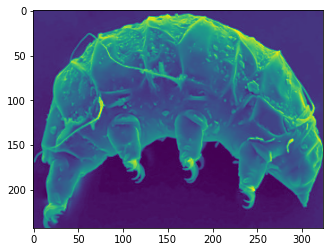

In [31]:
x=plt.imread('/home/rshuai/research/u-net-reconstruction/data/real-data/waterbear.jpg')
x=transform.resize(x[:,80:500], (486//2,648//2), order=3)
x=np.mean(x,2)
plt.imshow(x)

18288.37140187723


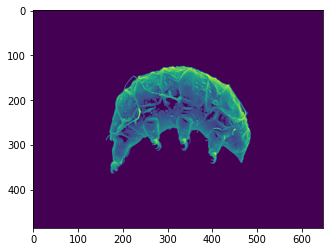

In [28]:
x=plt.imread('/home/rshuai/research/u-net-reconstruction/data/real-data/waterbear.jpg')
x=transform.resize(x[:,80:500], (np.shape(h)[0]//2,np.shape(h)[1]//2), order=3)
x=np.mean(x,2)
x=x*(x>0.2)
x=x/np.max(x)
x=pad2d(x)
c=np.zeros((1,648))
x=np.vstack((x,c))
# point source
x2=np.zeros((np.shape(h)[0],np.shape(h)[1]))
x2[np.shape(h)[0]//2:np.shape(h)[0]//2+3,np.shape(h)[1]//2:np.shape(h)[1]//2+3]=1

plt.imshow(x)
print(np.sum(np.abs(x)))

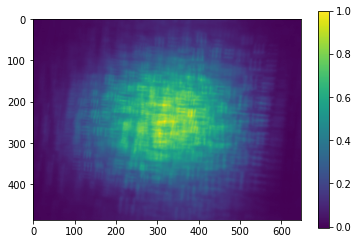

In [13]:
#y=A_2d(x,psf,nopad)#,rcL,rcU,ccL,ccU)
#y=crop2d(A_2d_svd(x,H[:,:,0,:],weights[:,:,0,:],pad2d),rcL,rcU,ccL,ccU)
x3d=[x,xtrue]
x3d=np.swapaxes(np.swapaxes(x3d,0,1),1,2)

#test2=A_3d_adj_svd(test,weights[:,:,0:2,:],Hnp[:,:,0:2,:],nopad)
# y3d=A_3d_svd(x3d,weights[:,:,29:31,:],Hnp[:,:,29:31,:],nopad)+noise
# y3d=y3d/np.max(y3d)
ysim=A_2d_svd(xtrue,Hnp[:,:,0,:],weights[:,:,0,:],nopad)#,rcL,rcU,ccL,ccU) #THIS USES z=29
#y=A_2d(x,H[:,:,0,:],weights[:,:,0,:],pad2d)
#x_adj=crop2d(A_2d_adj(Hconj[:,:,0,:],weights[:,:,0,:],x,pad2d),rcL,rcU,ccL,ccU)
y2d=ysim/np.max(ysim)
plt.imshow(y2d)
plt.colorbar()


## This is imporant part
What you need to define here is 

y2d: your 2d simulated image. Can be the real res target data or simulated as in the cell above.
weights, this just has the weights and Hnp, this is the fourier transform of the components and they are not padded for speed. 

I left an example of it running below



In [11]:
from PIL import Image
import PIL

In [13]:
temp_dir = '/home/rshuai/research/u-net-reconstruction/data/datasets/dataset_1/temp'
temp_gt = np.load(os.path.join(temp_dir, 'temp_gt.npy')).T
temp_sim = np.load(os.path.join(temp_dir, 'temp_sim.npy')).T

In [22]:
res_target_path = '../data/real-data/res_target_z1.tif'

x = np.array(Image.open(res_target_path).resize((648, 486), resample=PIL.Image.NEAREST))
x = x / np.max(x)
x = np.maximum(x, 0)

y2d = x

In [14]:
# ysim=A_2d_svd(temp_gt,Hnp[:,:,0,:],weights[:,:,0,:],nopad)#,rcL,rcU,ccL,ccU) #THIS USES z=29
ysim=A_2d_svd(xtrue,Hnp[:,:,0,:],weights[:,:,0,:],nopad)#,rcL,rcU,ccL,ccU) # new res target
# ysim=A_2d_svd(x,Hnp[:,:,0,:],weights[:,:,0,:],nopad)#,rcL,rcU,ccL,ccU) # new res target



#y=A_2d(x,H[:,:,0,:],weights[:,:,0,:],pad2d)
#x_adj=crop2d(A_2d_adj(Hconj[:,:,0,:],weights[:,:,0,:],x,pad2d),rcL,rcU,ccL,ccU)
y2d=ysim/np.max(ysim)

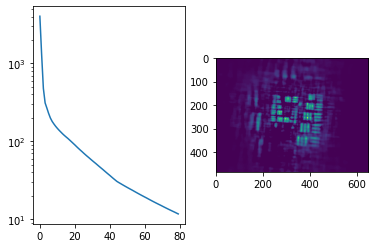

111.92978096008301


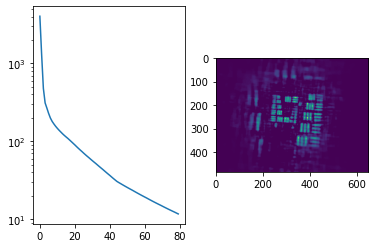

In [15]:
#things to do: 1) implement both iterative and soft_threshholding tv (wavelets)
#(this is only ture if this is inside an algorithm that will run for a while and only equivilant in convergence over time. So a single step here is not equal to iterative tV. Also, you should not threshhold the DC componenet, only the highpass. 
#IF I am only threhshoding the finite difference, then im ignoring TV. good.)
#note TV only looks good in convergence. This means waveletTV is not a single step TV denoiser. It only works well over time, so if used as denoiser, it needs to iterate. 
#The good thing is when used with deconvolution, it is already in a loop so single step is good. 
y=y2d
class settings(object):
     def __init__(self,stepsize,tau,tautv,tauwav,maxIter,residTol,convTol,plotting,proxnum,reg,tauhess,hess, dim):
            self.convTol=convTol
            self.maxIter=maxIter
            self.residTol=residTol
            self.stepsize=stepsize
            self.plotting=plotting
            self.tau=tau #L1 tau
            self.proxnum=proxnum
            self.reg=reg #this is regularizer for projected fista: l1,tv_l1,tv_iso or l1_tv_l1 (parallel projected fista L1 and TV iso) or l1_tv_iso
            self.tautv=tautv  #tv tau
            self.tauwav=tauwav
            
            self.tauhess=tauhess
            self.hess=hess
            self.dim=dim
            

dim='2d'
convTol = 0#15e-6 #wase-4
maxIter =  100
residTol = 5e-5
stepsize = 6e-2#for 2d 6e-2 #shift varying simulation  #5e-7 for shift invariant
plotting=1
tau=0.0001#*stepsize #*stepsize is just for prox_decomp, remove for the rest
tautv=0.0002 #same value for iterative vs haar
tauwav=0.0001
tauhess=0.0001 #hessian regularizer
proxnum=4
reg='tv_haar'
hess='fro_norm'
#reg='l1'
options= settings(stepsize,tau,tautv,tauwav,maxIter,residTol,convTol,plotting,proxnum,reg,tauhess,hess,dim)

n=np.shape(x)[0]


if options.dim=='2d':
    xinit=np.zeros((np.shape(x)[0],np.shape(x)[1]))
    #A = lambda x:crop2d(A_2d_svd(x,H,weights[:,:,29,:],pad2d),rcL,rcU,ccL,ccU)
    #Aadj = lambda y: crop2d(A_2d_adj_svd(Hconj,weights[:,:,29,:],y,pad2d),rcL,rcU,ccL,ccU)
    A = lambda x:A_2d_svd(x,Hnp[:,:,0,:],weights[:,:,0,:],nopad)
    Aadj = lambda y: A_2d_adj_svd(Hconjnp[:,:,0,:],weights[:,:,0,:],y,nopad)
    grad_handle = lambda x:linear_gradient_b(x, A, Aadj, y)  #this computes At(Ax-b) and returns it and also cost (Ax-b)
    #prox_handle= lambda x:(0.5*(np.maximum(x,0))+0.5*soft_thresh(x,options.tau*stepsize),options.tau*np.sum(np.abs(x)))
    #prox_handle= lambda x:(soft_thresh(x,options.tau*stepsize),options.tau*np.sum(np.abs(x)))
    prox_handle= lambda x: tvdenoise(x,options.tautv*stepsize,10, opt='iso',plot=0)
    #handles for prox_decomp
    Afor = lambda x: x+Aadj(A(x))*options.proxnum
    # prox1= lambda x: np.maximum(x,0)
    # prox2= lambda x: soft_thresh(x,options.tau*prox_decomp_handle.proxnum)
    # prox3= lambda x:conjgrad(Afro,x+Aadj(y)*prox_decomp_handle.proxnum,xinit,10)

    t0 = time.time()
    #[xhat, loss_total,loss_df,loss_norm] = fista_nonneg(grad_handle,prox_handle,xinit,y,options)
    #xhat=prox_decomp(grad_handle,prox_handle,Aadj,Afor,xinit,y,options)
    [xhat, loss_total,loss_df,loss_norm,t_vis] = projected_fista(grad_handle,prox_handle,xinit,y,options)
    #[xhat, loss_total,loss_df,loss_norm,t_vis] = parallel_projected_fista(grad_handle,prox_handle,xinit,y,options)
    #[xhat, loss_total,loss_df,loss_norm] = fista(grad_handle,prox_handle,xinit,y,options)
    #[xhat, loss_total,loss_df,loss_norm] = parallel_prox(grad_handle,prox_handle,xinit,ysim,options)

    t1 = time.time()

    total_time = t1-t0
    print(total_time)
    
elif options.dim=='3d':
#     x=[x,x]
#     x=np.swapaxes(np.swapaxes(x,0,1),1,2)
    xinit=np.zeros((np.shape(x3d)[0],np.shape(x3d)[1], np.shape(x3d)[2]))
    #test2=A_3d_adj_svd(test,weights[:,:,0:2,:],Hnp[:,:,0:2,:],nopad)
    A = lambda x:A_3d_svd(x,weights[:,:,29:31,:],Hnp[:,:,29:31,:],nopad)
    Aadj = lambda y: A_3d_adj_svd(y,weights[:,:,29:31,:],Hnp[:,:,29:31,:],nopad)
    grad_handle = lambda x:linear_gradient_b(x, A, Aadj, y)  #this computes At(Ax-b) and returns it and also cost (Ax-b)
    #prox_handle= lambda x: tvdenoise(x,options.tautv*stepsize,10, opt='iso',plot=0)
    prox_handle= lambda x:tv3d_iso_haar(x,0.0001*options.stepsize,1,plot=0)
    #prox_handle= lambda x:(soft_thresh(x,0.0001*options.stepsize),np.sum(np.abs(x)))
    #handles for prox_decomp
    Afor = lambda x: x+Aadj(A(x))*options.proxnum
    
    
    t0 = time.time()
    #[xhat, loss_total,loss_df,loss_norm] = fista_nonneg(grad_handle,prox_handle,xinit,y,options)
    #xhat=prox_decomp(grad_handle,prox_handle,Aadj,Afor,xinit,y,options)
    [xhat, loss_total,loss_df,loss_norm,t_vis] = projected_fista(grad_handle,prox_handle,xinit,y,options)
    #[xhat, loss_total,loss_df,loss_norm,t_vis] = parallel_projected_fista(grad_handle,prox_handle,xinit,y,options)
    #[xhat, loss_total,loss_df,loss_norm] = fista(grad_handle,prox_handle,xinit,y,options)
    #[xhat, loss_total,loss_df,loss_norm] = parallel_prox(grad_handle,prox_handle,xinit,ysim,options)

    t1 = time.time()

    total_time = t1-t0
    print(total_time)
    

#plt.imshow(xhat)



#TVnorm3d = @(x)sum(sum(sum(abs(x))));
#prox_handle = @(x)deal(.5*tv2d_aniso_haar(x,params.tau1*options.stepsize) +.5*max(x,0), params.tau1*options.stepsize*TVnorm(x));

#

#other prox
# #3d prox
# prox_handle = @(x)deal(1/2*(max(x,0) + (tv3d_iso_Haar((x), params.tau1, params.z_tv_weight))), params.tau1*TVnorm3d(x));
# #2d prox

# prox_handle = @(x)deal(.5*(soft(x,params.tau_soft) +tv3d_iso_Haar(x, params.tau1, params.z_tv_weight)),params.tau1*TVnorm3d(x));
            
# prox_handle = @(x)deal(soft(tv3d_iso_Haar(x, params.tau1, params.z_tv_weight),params.tau_soft),params.tau1*TVnorm3d(x));





# params.tau1 = gpuArray(params.tau1);
# params.tau_soft = gpuArray(params.tau_soft);
# tau_iso = gpuArray(tau_iso);
# params.z_tv_weight = gpuArray(params.z_tv_weight);
# options.stepsize = gpuArray(options.stepsize);

In [9]:
print('done')

done


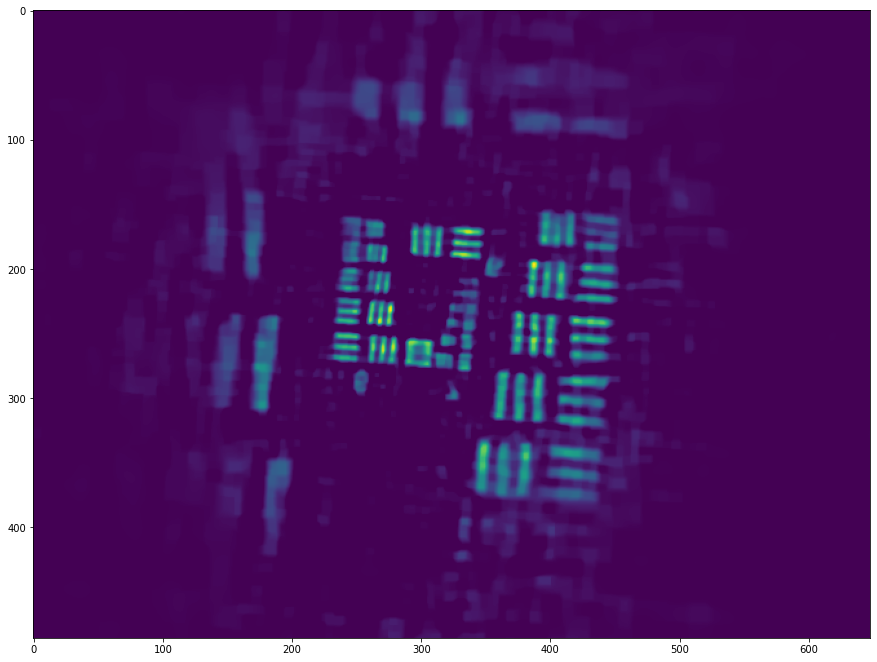

In [16]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(xhat)
plt.show()

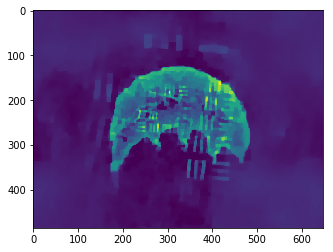

In [178]:
plt.imshow(xhat[:,:,0])

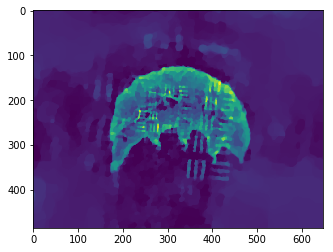

In [174]:
plt.imshow(xhat[:,:,0])

1.0


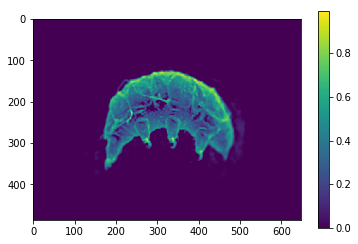

In [1453]:
#L1 only result
plt.imshow(xhat)
plt.colorbar()
xhat=xhat/np.max(xhat)
print(np.max(xhat))
plt.imsave('bear_hessp2_0_1threg.png',xhat)
#plt.plot(np.array(t_vis))

In [ ]:
mu=0.02 #noise mean
std=0.005  #noise std

noise=np.reshape(np.random.normal(mu,std,np.shape(x)[0]*np.shape(x)[1]),(np.shape(x)[0],np.shape(x)[1]))
#testl1=tvdenoise(x+noise,0.1,20,opt='l1')
#testl2=tvdenoise(x+noise,0.1,20,opt='iso',plot=1)
im=x+noise
options.maxIter=100
options.tauhess=0.01
#[out,re,P,R] = hessian_prox(grad_handle,prox_handle,xinit,x+noise,options,plot=0)
# for i in range(20):
    
#     testtvhar=tv2d_aniso_haar(im,0.1,1)
#     im=testtvhar
plt.plot(np.ravel(noise))

In [1426]:
plt.imsave('bear_gt.png',x)

In [1019]:
np.shape(np.zeros((np.shape(y)[0],np.shape(y)[1],2)))

(486, 648, 2)

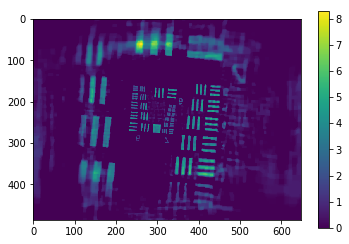

In [13]:
#L1 only result
plt.imshow(xhat)
plt.colorbar()
#plt.plot(np.array(t_vis))

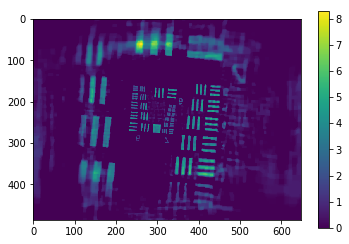

In [394]:
#tv result
plt.imshow(xhat)
plt.colorbar()
#plt.plot(np.array(t_vis))

In [ ]:
#wavelet result
plt.imshow(xhat)
plt.colorbar()
#plt.plot(np.array(t_vis))

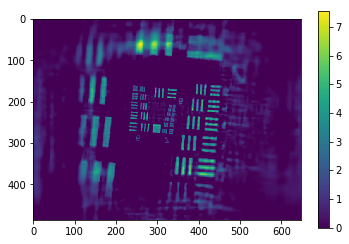

In [383]:
plt.imshow(xhat)
plt.colorbar()
#plt.plot(np.array(t_vis))

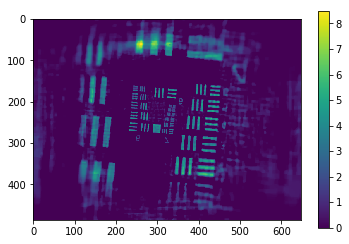

In [47]:
plt.imshow(xhat)
plt.colorbar()
#plt.plot(np.array(t_vis))

In [ ]:
ytest2=crop2d(A_2d_svd(xtrue,H[:,:,29,:],weights[:,:,29,:],pad2d),rcL,rcU,ccL,ccU)
plt.subplot(1,2,1)
plt.imshow(y)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(ytest2)
plt.colorbar()

In [ ]:
ytest=A_2d_svd(xtrue,Hnp[:,:,29,:],weights[:,:,29,:],nopad)
plt.subplot(1,2,1)
plt.imshow(y)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(ytest/np.max(ytest),vmin=0, vmax=1)
plt.colorbar()

In [ ]:
plt.imshow(xhat)
plt.colorbar()
#plt.plot(np.array(t_vis))

In [ ]:
plt.plot(np.array(t_vis))

In [ ]:
# options={}
# options['convTol'] = 15e-4;
# options['maxIter'] = 1000;
# options['residTol'] = 5e-5;
# options['momentum']= 'nesterov'
# options['stepsize'] = 6e-2  #5e-7 for shift invariant
# n=np.shape(x)[0]
# xinit=np.zeros((np.shape(x)[0],np.shape(x)[1]))
# alpha=options['stepsize']
# loss=[]

# ##fista

# pk=xinit
# tk=1
# for i in range(0,options['maxIter']):  

#     #L=crop2d(A_2d_svd(pk,H[:,:,0,:],weights[:,:,0,:],pad2d),rcL,rcU,ccL,ccU)-y
#     #wk=pk-crop2d(alpha*A_2d_adj_svd(Hconj[:,:,0,:],weights[:,:,0,:],L,pad2d),rcL,rcU,ccL,ccU)
#     L=A_2d_svd(pk,Hnp[:,:,0,:],weights[:,:,0,:],nopad)-y
#     wk=pk-alpha*A_2d_adj_svd(Hconjnp[:,:,0,:],weights[:,:,0,:],L,nopad)
#     #L=A_2d(xinit,psf,nopad)-y
#     #xinit=xinit-alpha*A_2d_adj(L,psf,nopad)
#     xk1=soft_thresh(wk,options['stepsize']*0.0001)  #30 for shiftinvariant
#     xk1=np.maximum(xk1,0)
#     tk1 = (1+np.sqrt(1+4*tk))/2
#     pk = xk1 + (tk-1)/tk1*(xk1 - xinit)
#     xinit=xk1.copy();tk=tk1.copy()
#     #xinit=np.maximum(xk1,0)
#     loss.append(np.linalg.norm(L))
#     if (np.mod(i,10)==0):
#         plt.subplot(1,2,1)
#         pl.plot(loss)
#         display.clear_output(wait=True)
#         display.display(pl.gcf())
#         plt.subplot(1,2,2)
#         plt.imshow(xinit)
#         #time.sleep(0.005)